# This notebook analyzes the anomaly of the high amount of cancelled data at the end of 2016

In [32]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pandas_profiling
import datetime

In [8]:
df = pd.read_csv("sample_data_short_CLEAN.csv", sep=",")
df_dof = pd.read_csv("sample_data_short_CLEAN_DOF_GROUPBY.csv", sep=",")

/home/bcoelho/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1349779, 33)

In [16]:
df_dof.nunique()

nome_remetente           1475
cpf_remetente            1299
uf_origem                   2
municipio_origem           69
cd_mun_origem              69
latitude_origem            69
longitude_origem           69
ctf_remetente            1332
uf_destino                 26
municipio_destino        2182
cd_mun_destino           2219
latitude_destino         2219
longitude_destino        2219
nome_destinatario       31336
cpf_destinatario        14396
dt_emissao                982
ano                         3
dt_validade_inicial       989
dt_validade_final         998
ultima_transacao            9
dt_ultima_transacao       983
numero_serie_dof       475764
codigo_controle_dof    475764
rota_transporte         13850
volume                 155503
valor                  252102
dtype: int64

# Analize only a specific sub period with anomaly

In [108]:
df["dt_emissao"] = pd.to_datetime(df["dt_emissao"])
idx = (datetime.datetime(2016, 12, 1) < df["dt_emissao"]) & ( df["dt_emissao"] < datetime.datetime(2017, 1, 29))
sub_period = df[idx]

df_dof["dt_emissao"] = pd.to_datetime(df_dof["dt_emissao"])
idx = (datetime.datetime(2016, 12, 1) < df_dof["dt_emissao"]) & ( df_dof["dt_emissao"] < datetime.datetime(2017, 1, 29))
sub_period_dof = df_dof[idx]

In [109]:
time_col = "dt_emissao"

def stacked_area_plot(df, amount_cols=10, show=True):
    cols = df[TARGET_COL].value_counts(sort=True, ascending=False).index
    
    # We must calculate on all the data to not skew the plot %
    data = pd.DataFrame()
    for name, group in df.groupby(TARGET_COL):
        data[name] = group.groupby(group[time_col].dt.date).size()
    data_perc = data.divide(data.sum(axis=1), axis=0)
    data_perc.fillna(0, inplace=True)

    for col_idx in range(1):
        plt.figure(figsize=(32, 18))
        use_cols = cols[col_idx*amount_cols: col_idx*amount_cols + amount_cols]
        use_data = [data_perc[x] for x in use_cols]
        plt.stackplot(data_perc.index,  *use_data, labels=use_cols)
        plt.xticks(rotation=90)
        plt.legend(loc='lower left')
        plt.title(f"Distribuição pelo tempo de {TARGET_COL}")
        plt.margins(0,0)
        if show:
            plt.show()

In [110]:
def line_plot_over_time(df, amount_cols=10, show=True):
    # Print over years
    print("Average per year")
    if show:
        plt.figure(figsize=(32, 18))
    sns.lineplot(data=df.groupby(time_col).size())
    
    plt.show()

In [111]:
def seasonality_plots(df):
    time_groups = ["Weekly", "Monthly"]
    orders = [['Monday', 'Tuesday', 'Wednesday',  'Thursday', 'Friday', 
             'Saturday', 'Sunday'],
              ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
            'August', 'September', 'October', 'November', 'December']]

    for time_group, order in zip(time_groups, orders):
        print(f"{time_group} # by category")
        for name, group in df.groupby(TARGET_COL):
            print(name)
            
            if time_group == "Weekly":
                temp = df.groupby(group[time_col].dt.day_name(), as_index=False)
            else: 
                temp = df.groupby(group[time_col].dt.month_name(), as_index=False)

            temp = temp.size().reset_index()
            sns.barplot(data=temp, y=0, x="dt_emissao", order=order)
            plt.xticks(rotation=90)
            plt.ylabel(name)
            plt.show() 


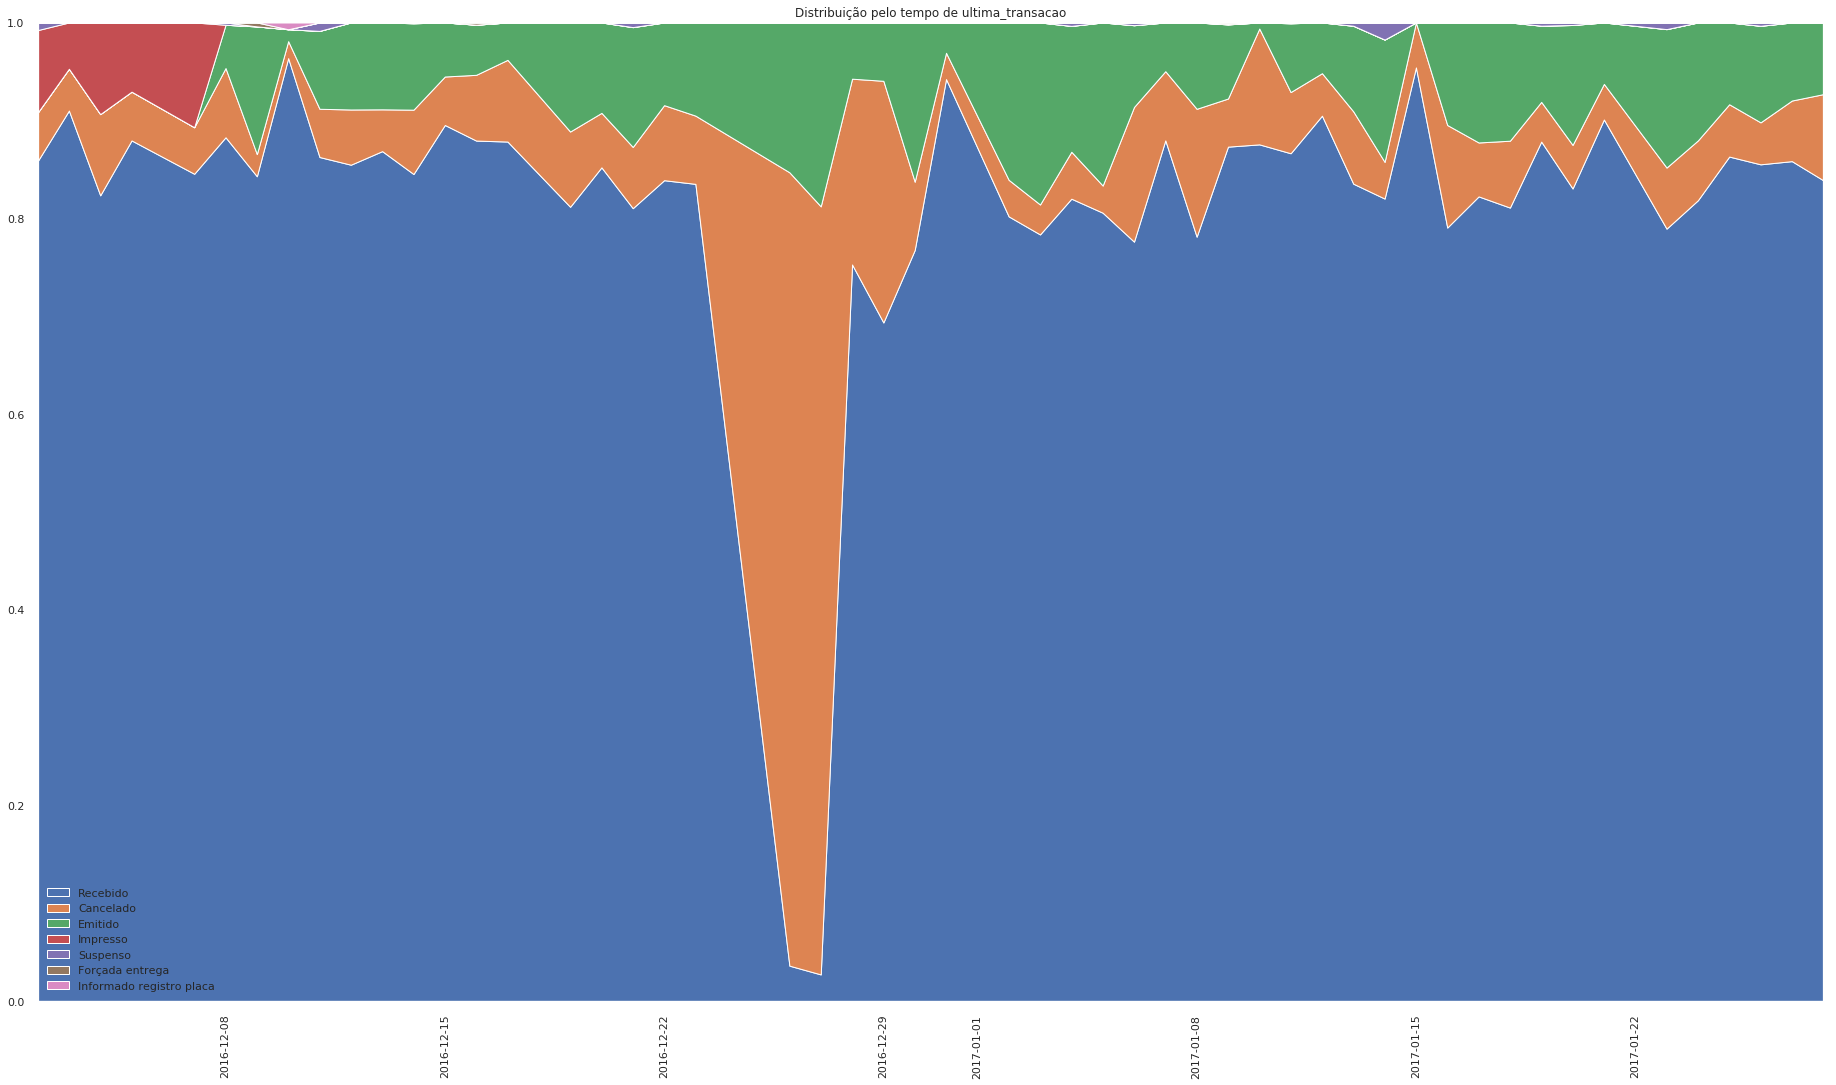

Average per year


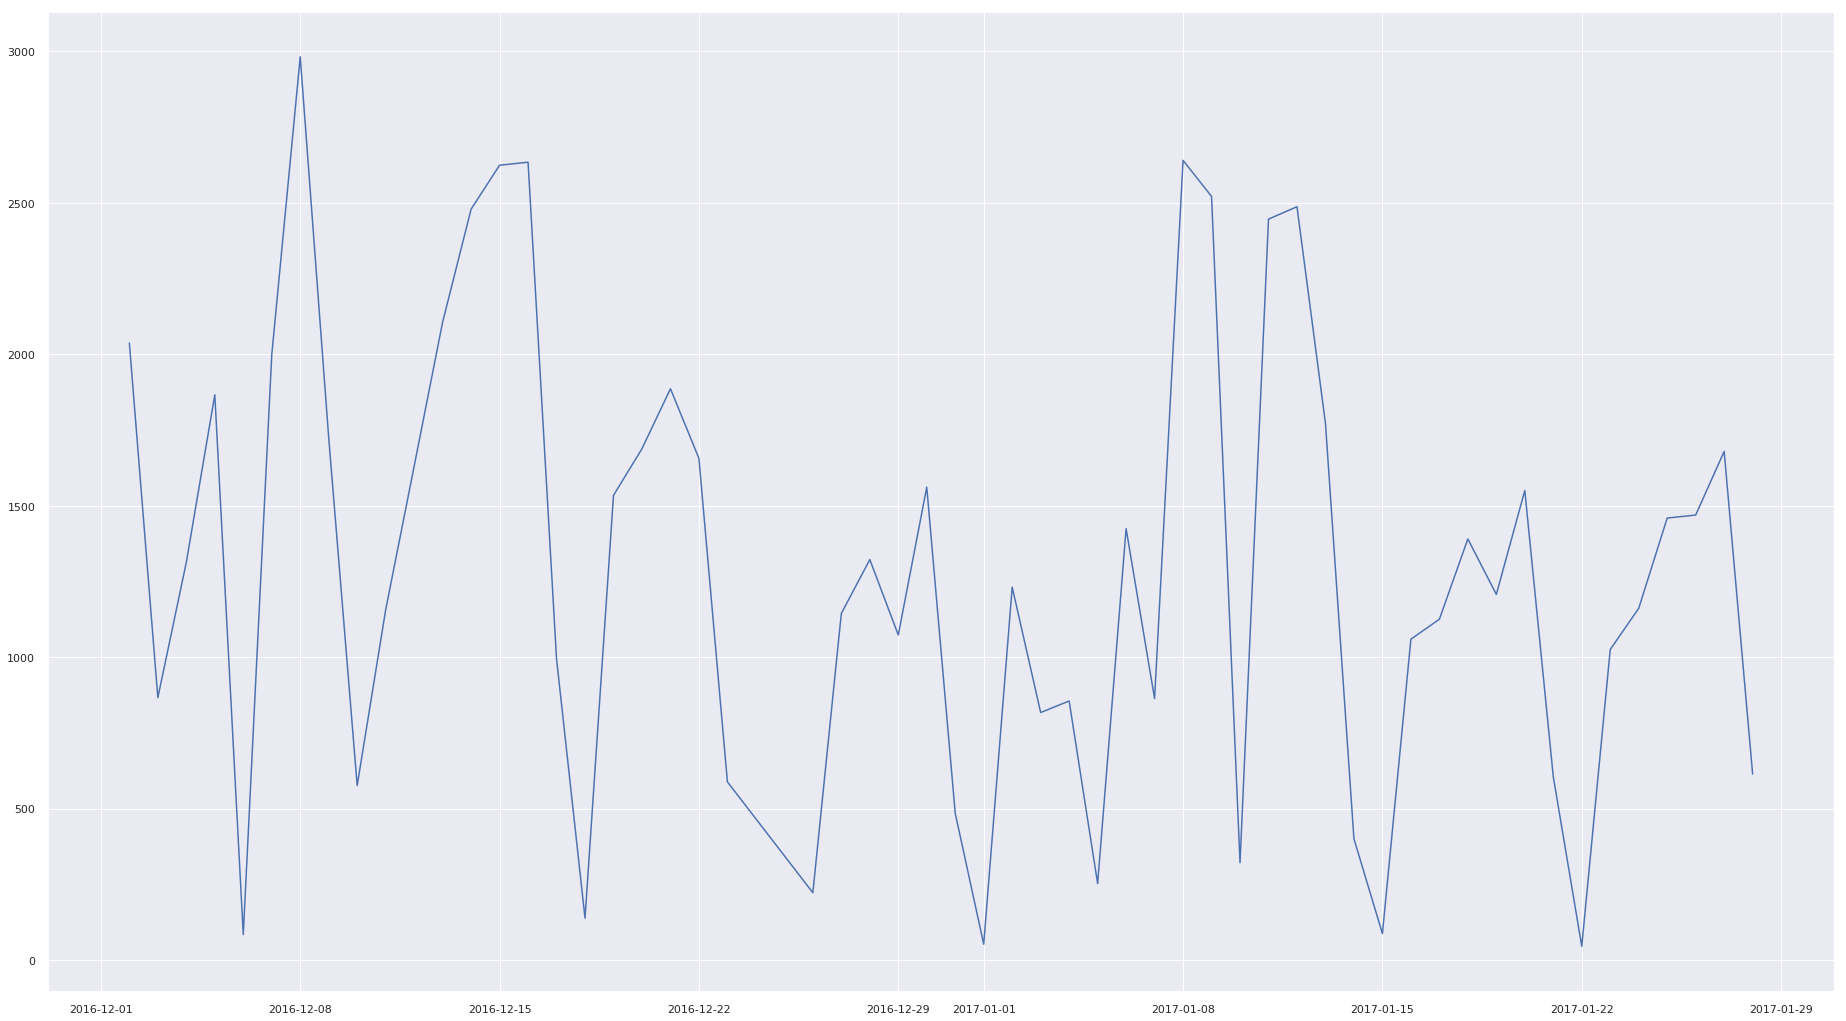

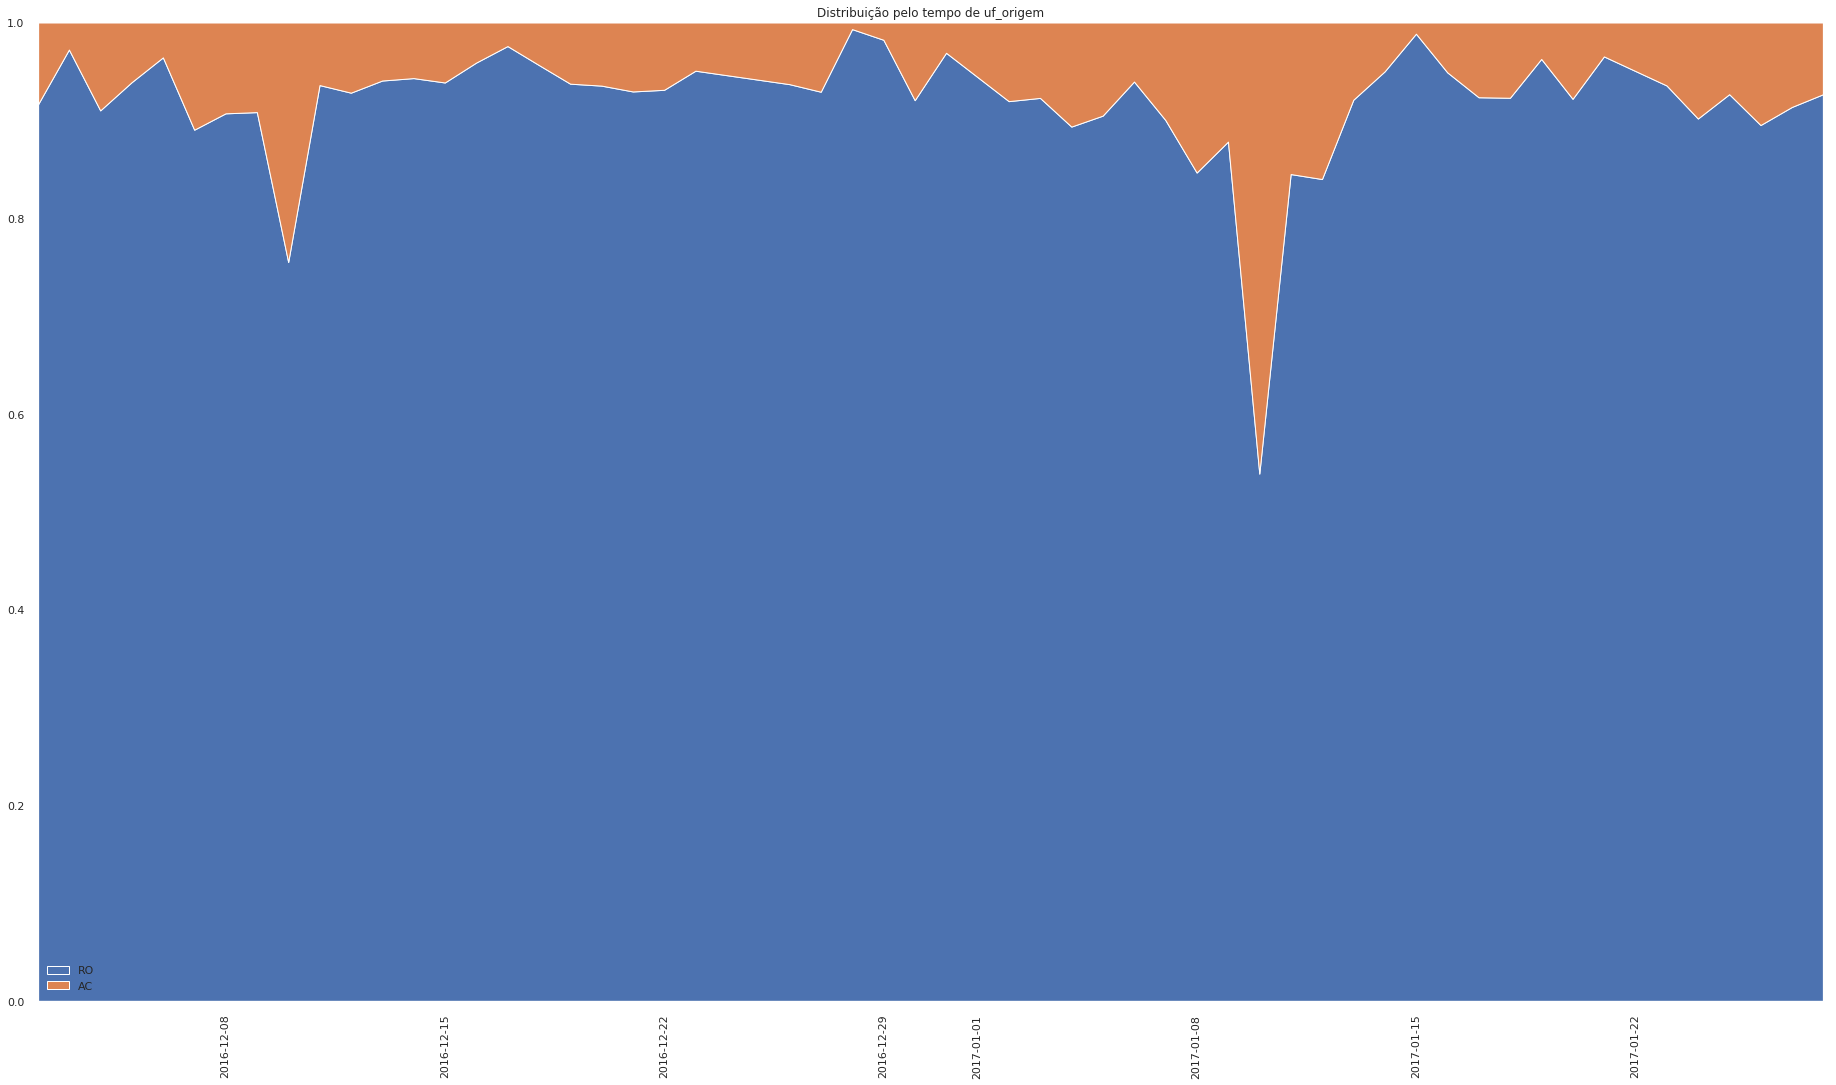

Average per year


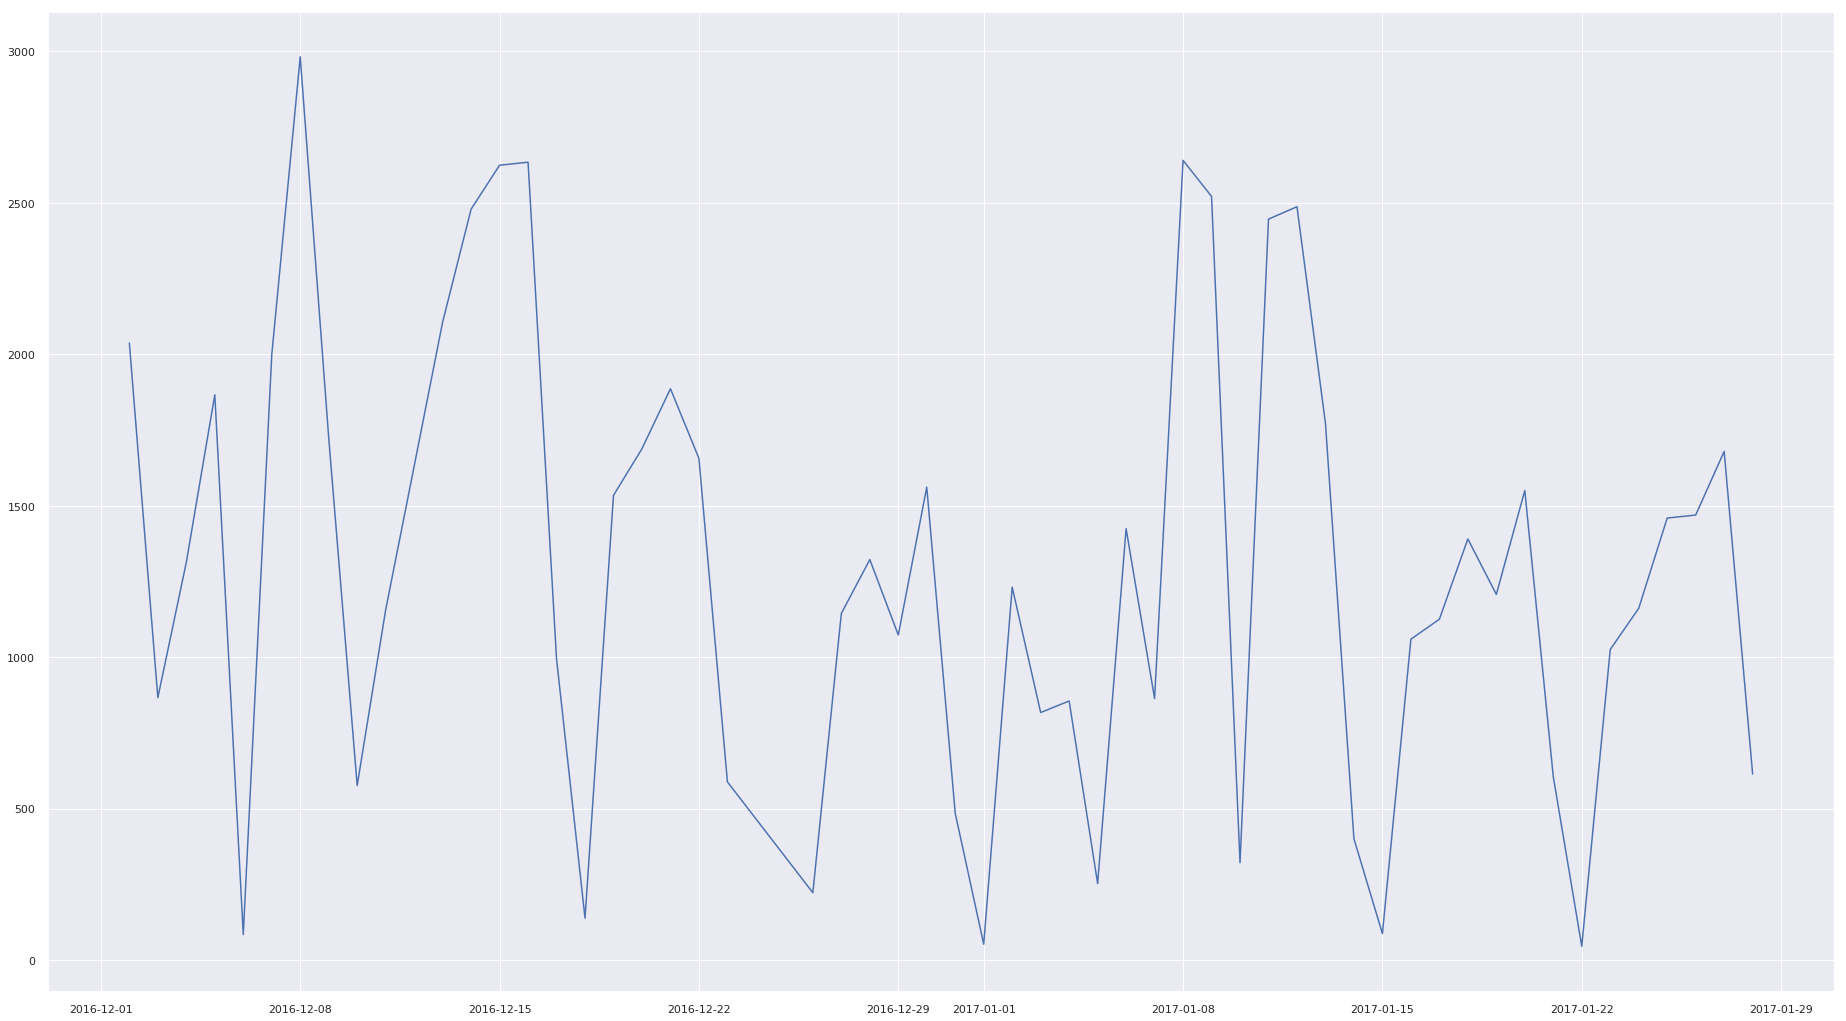

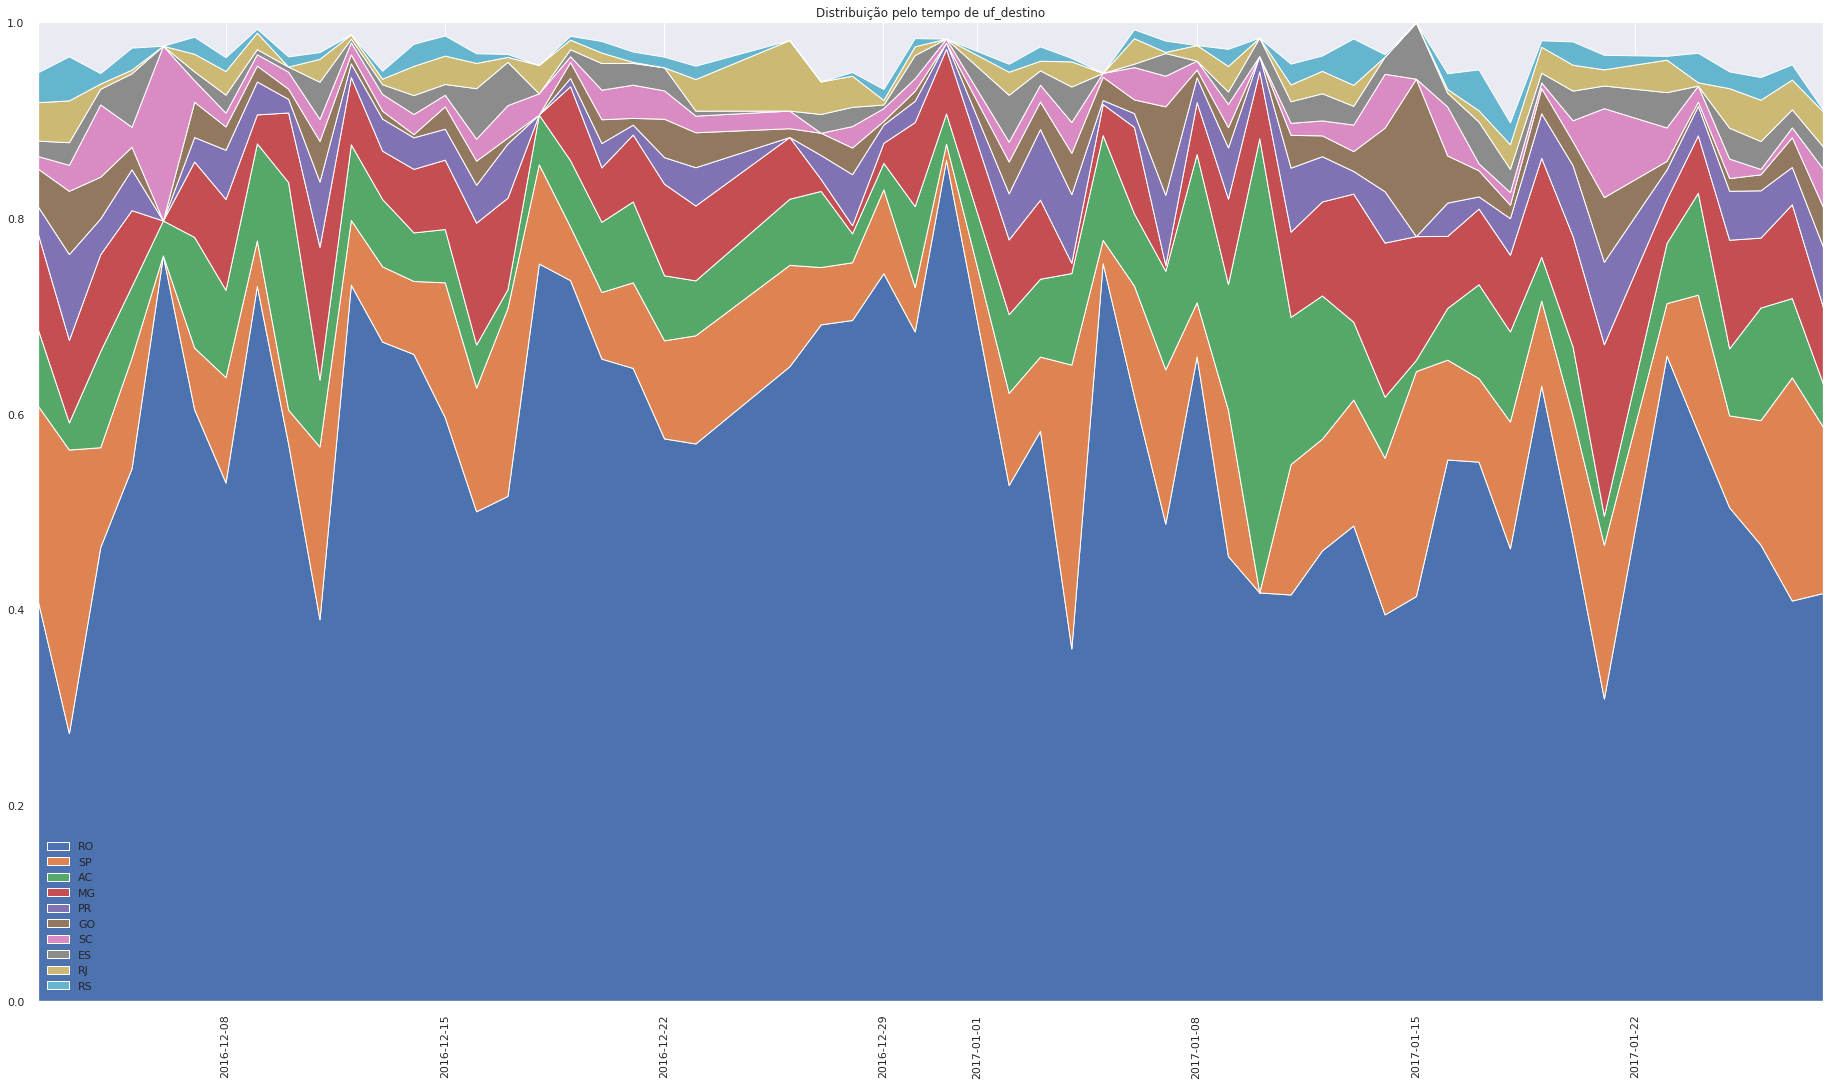

Average per year


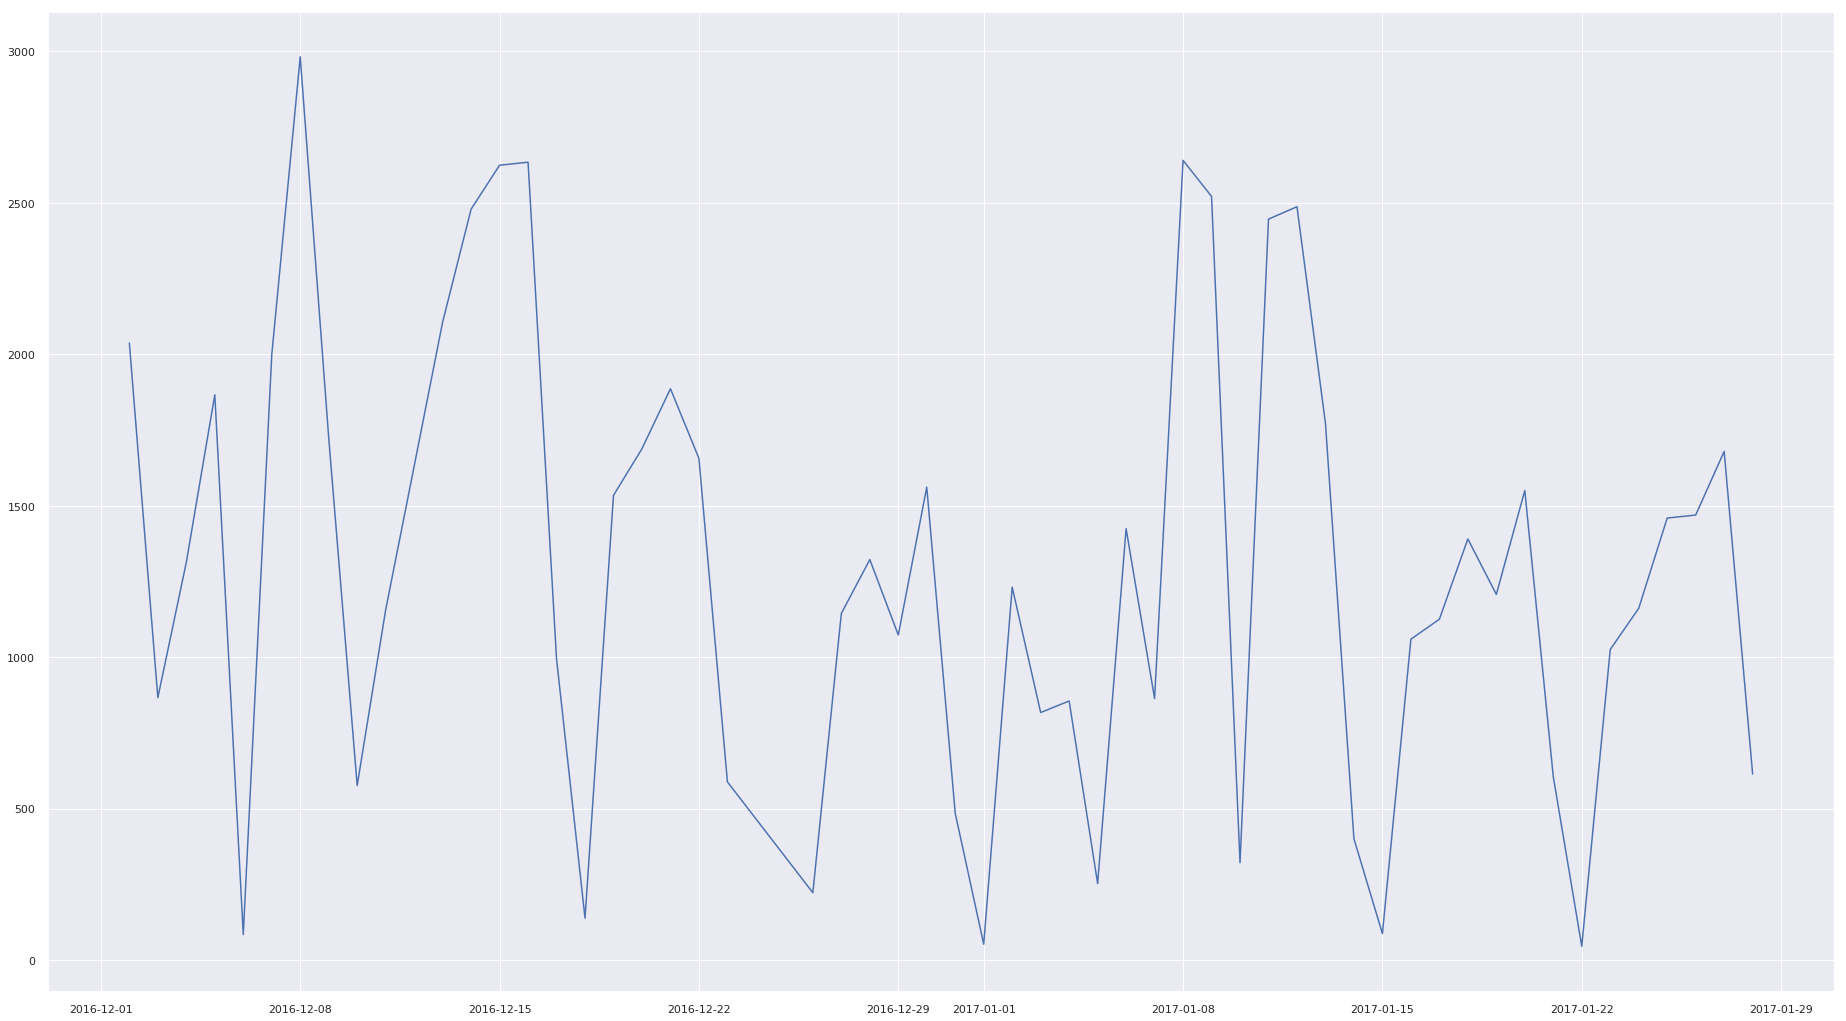

In [112]:
for col in ["ultima_transacao", "uf_origem", "uf_destino"]:
    TARGET_COL = col
    stacked_area_plot(sub_period, 10)
    line_plot_over_time(sub_period, amount_cols=10)

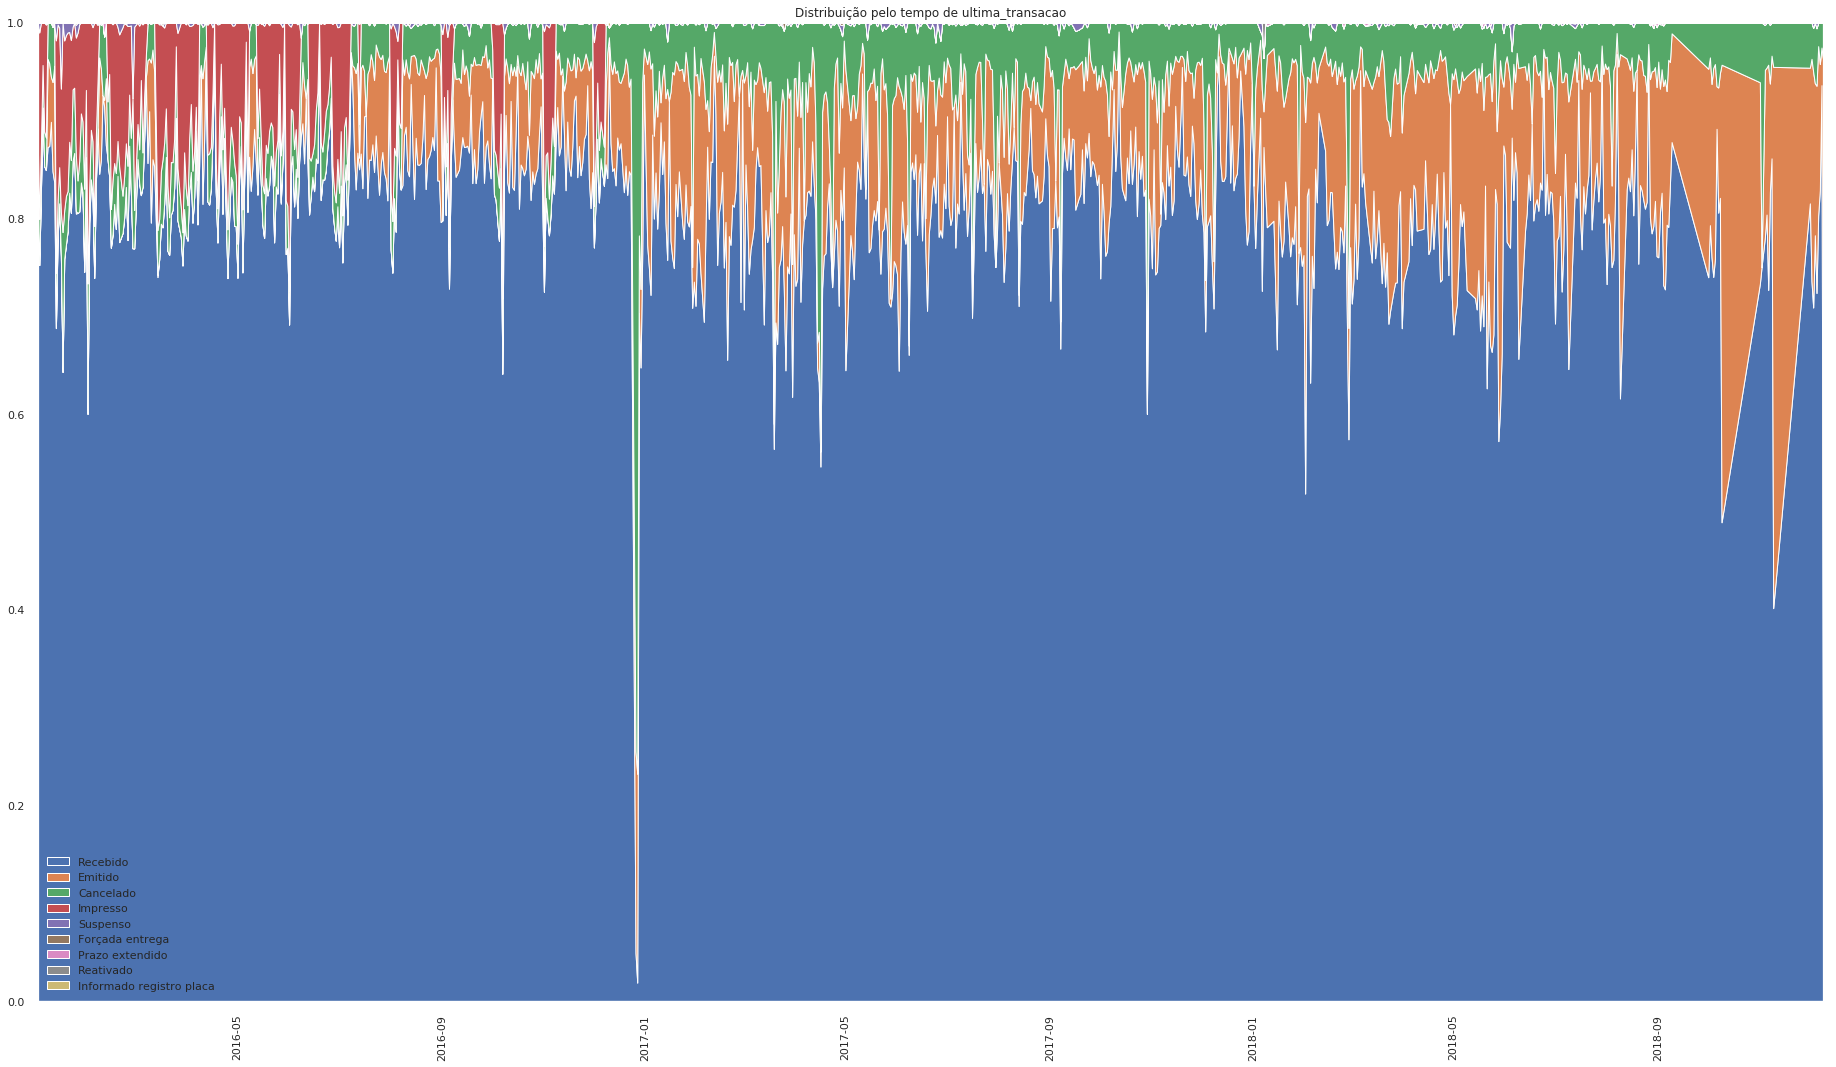

Average per year


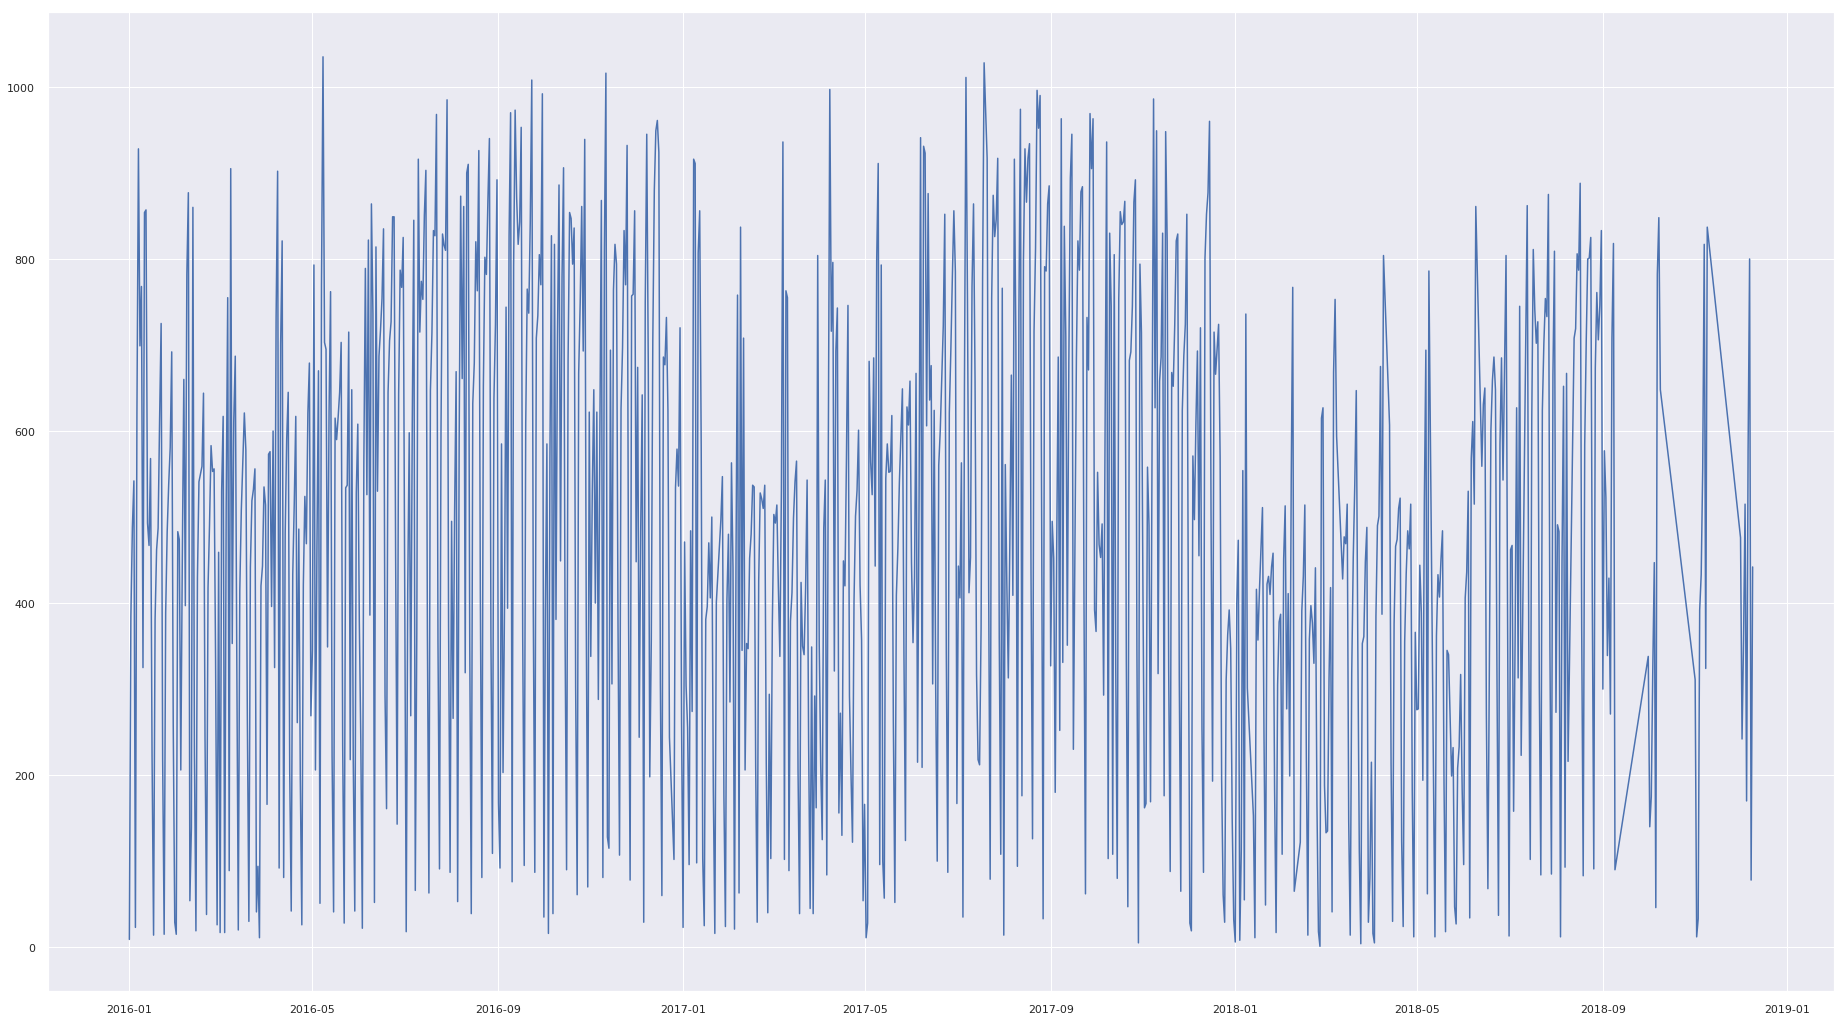

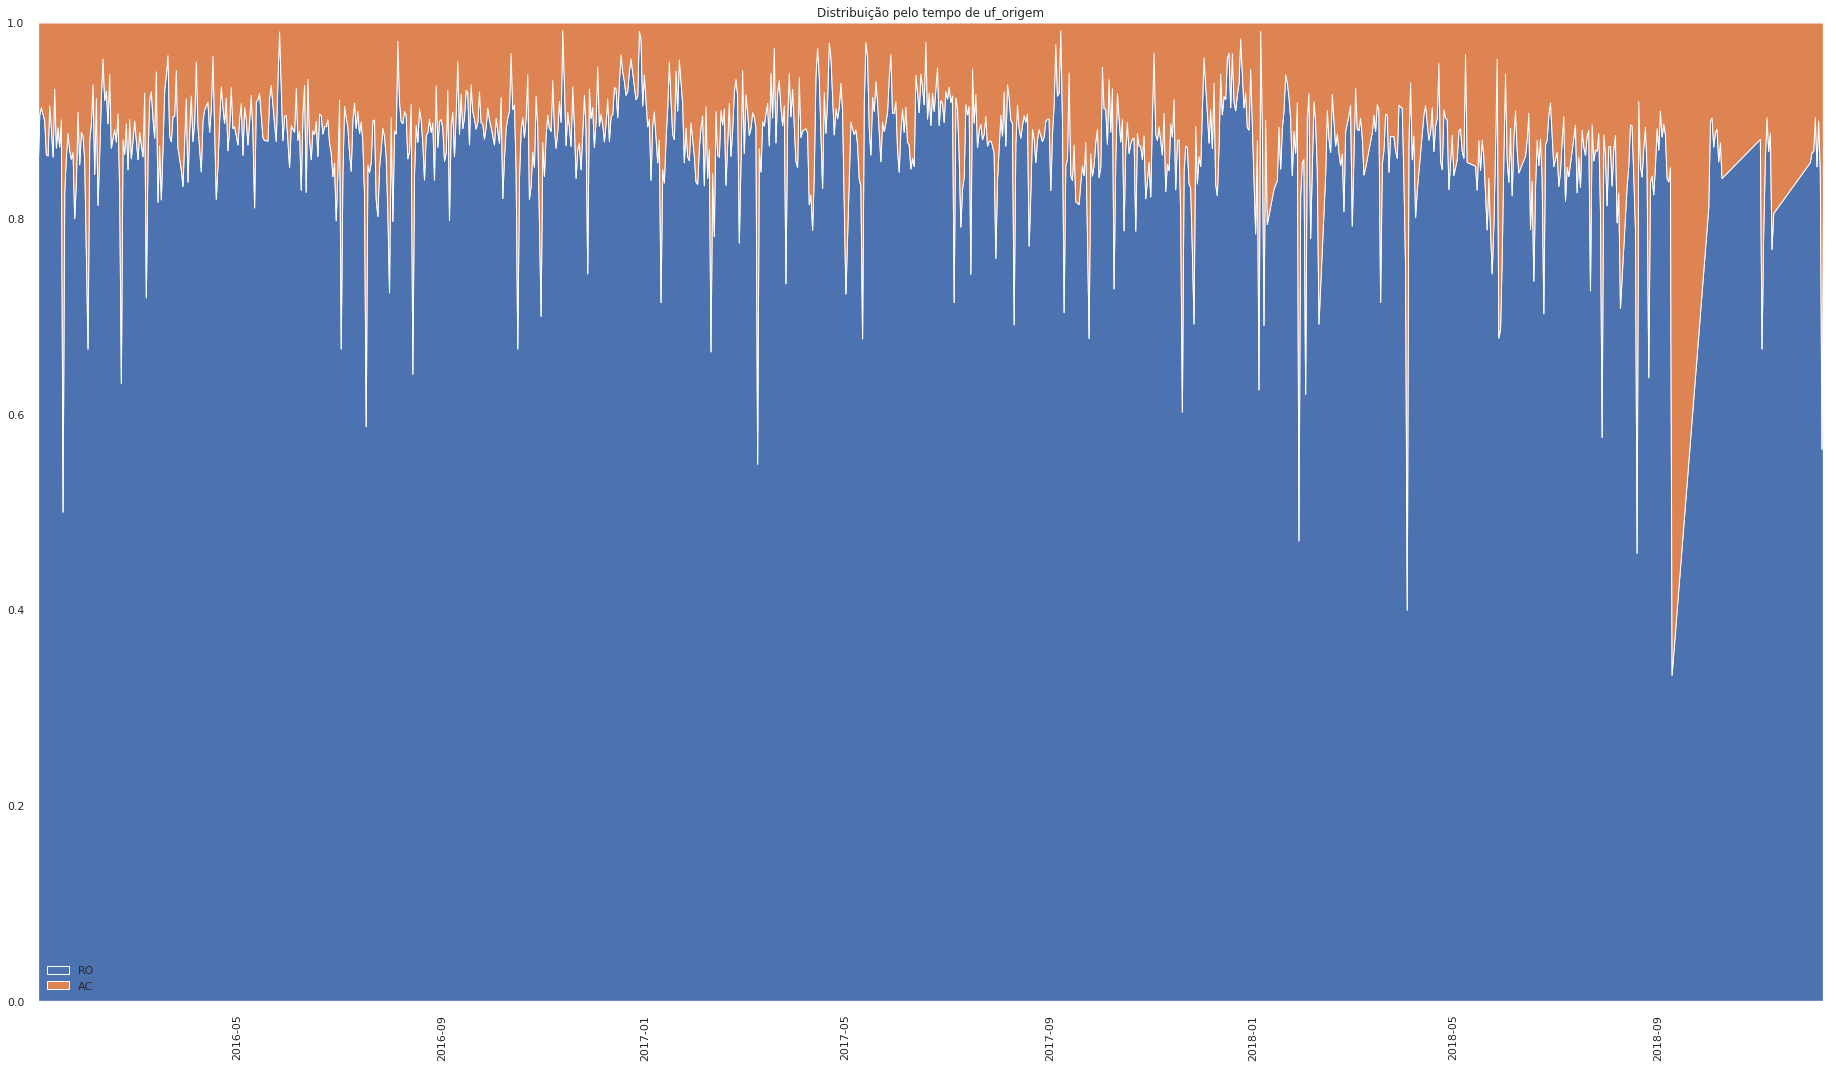

Average per year


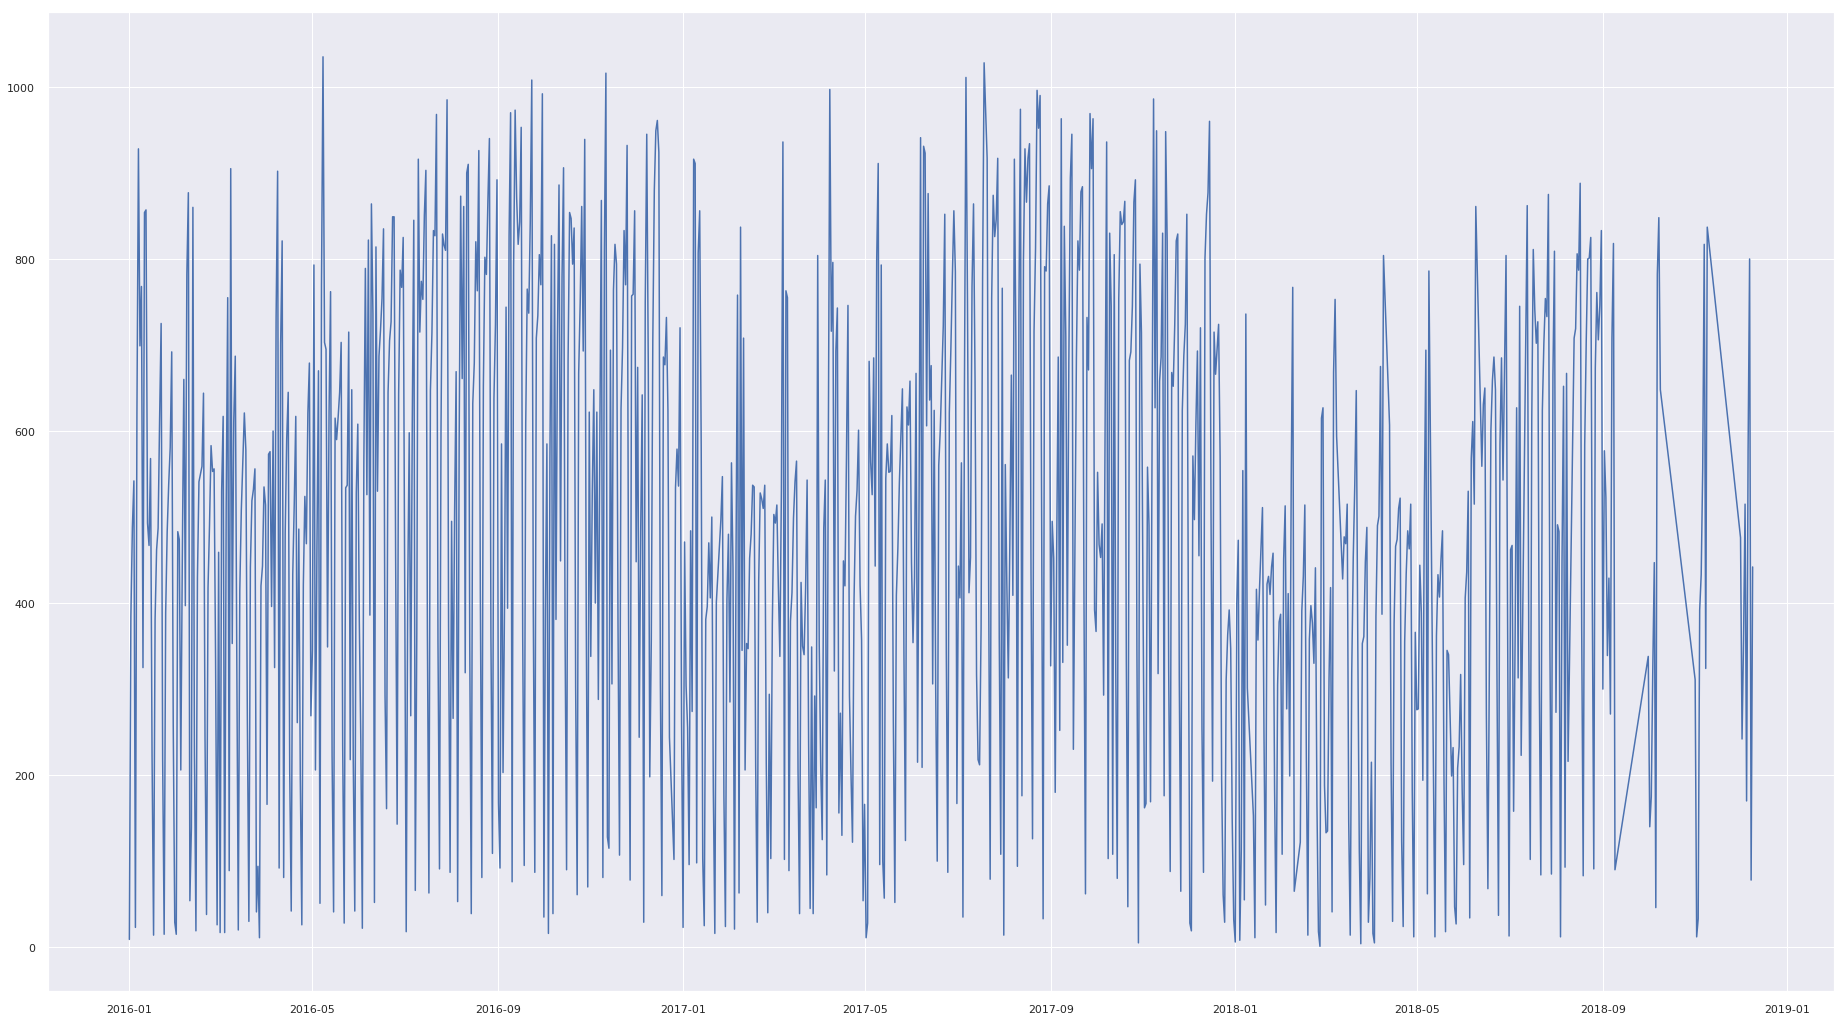

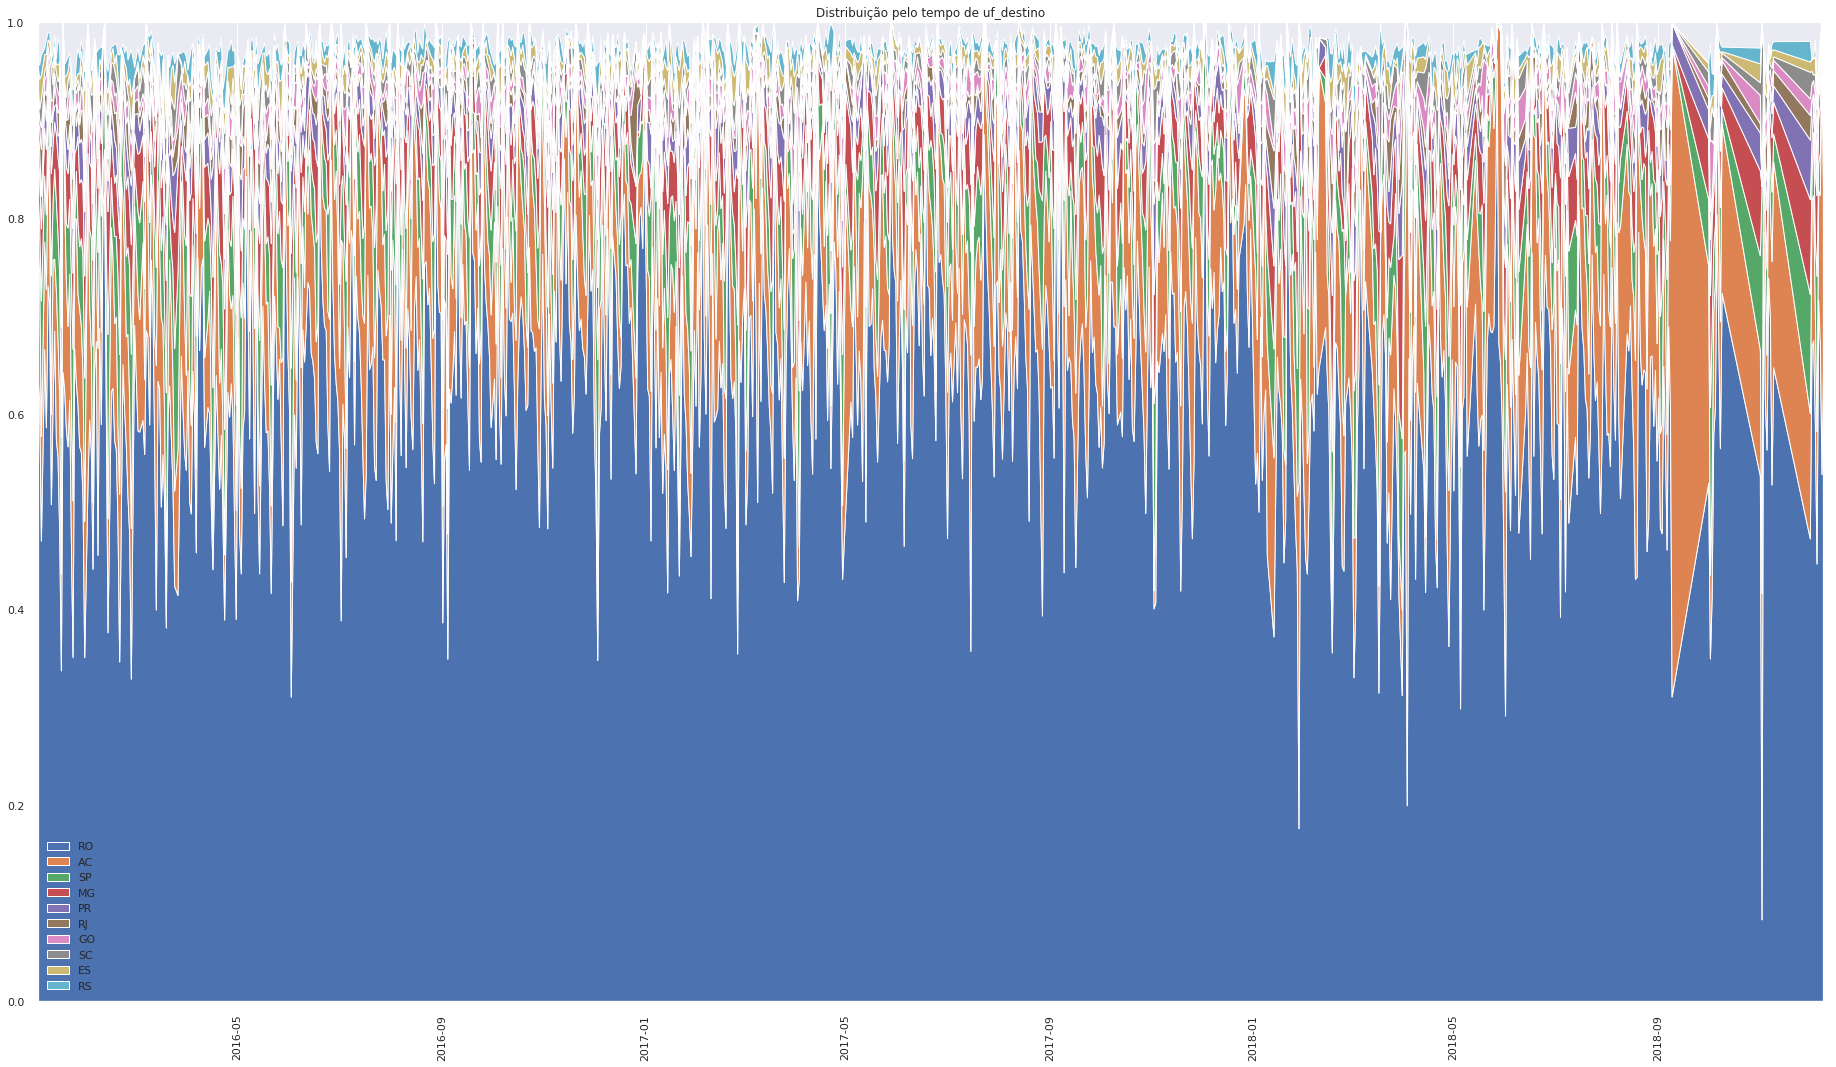

Average per year


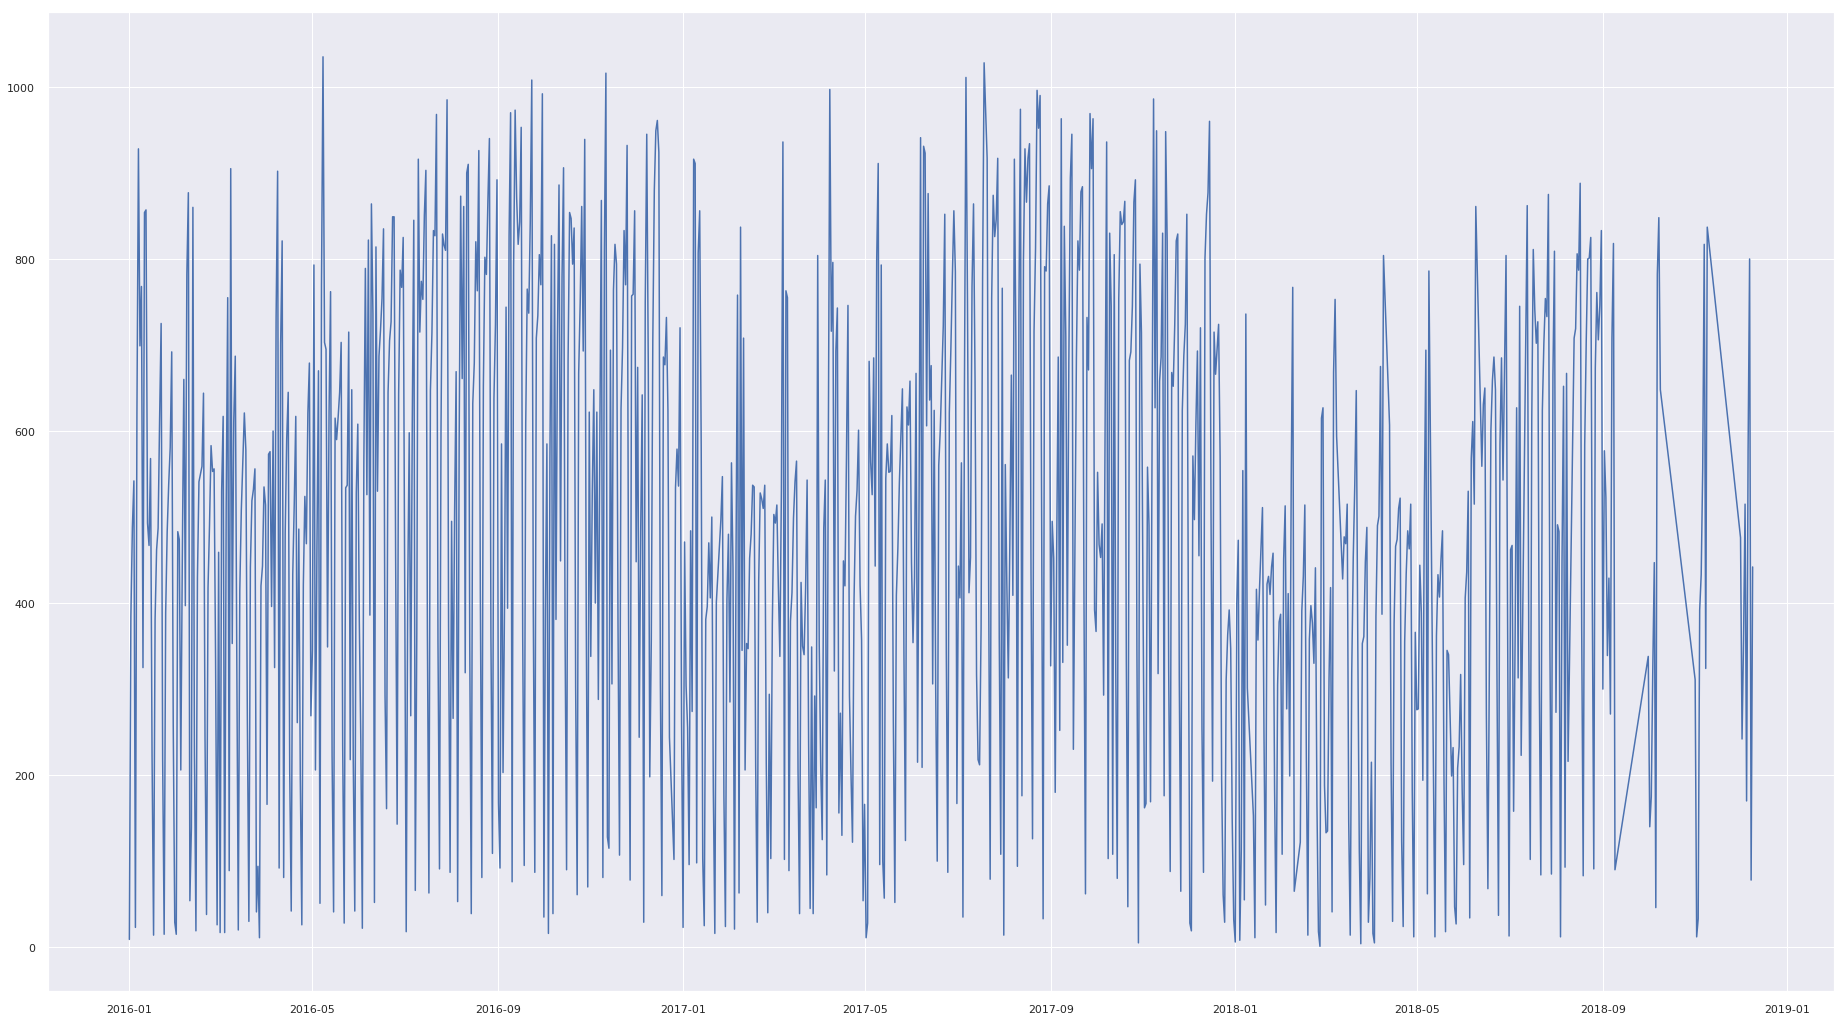

In [113]:
for col in ["ultima_transacao", "uf_origem", "uf_destino"]:
    TARGET_COL = col
    stacked_area_plot(df_dof, 10)
    line_plot_over_time(df_dof, amount_cols=10)

# Analyze more close up the anomaly

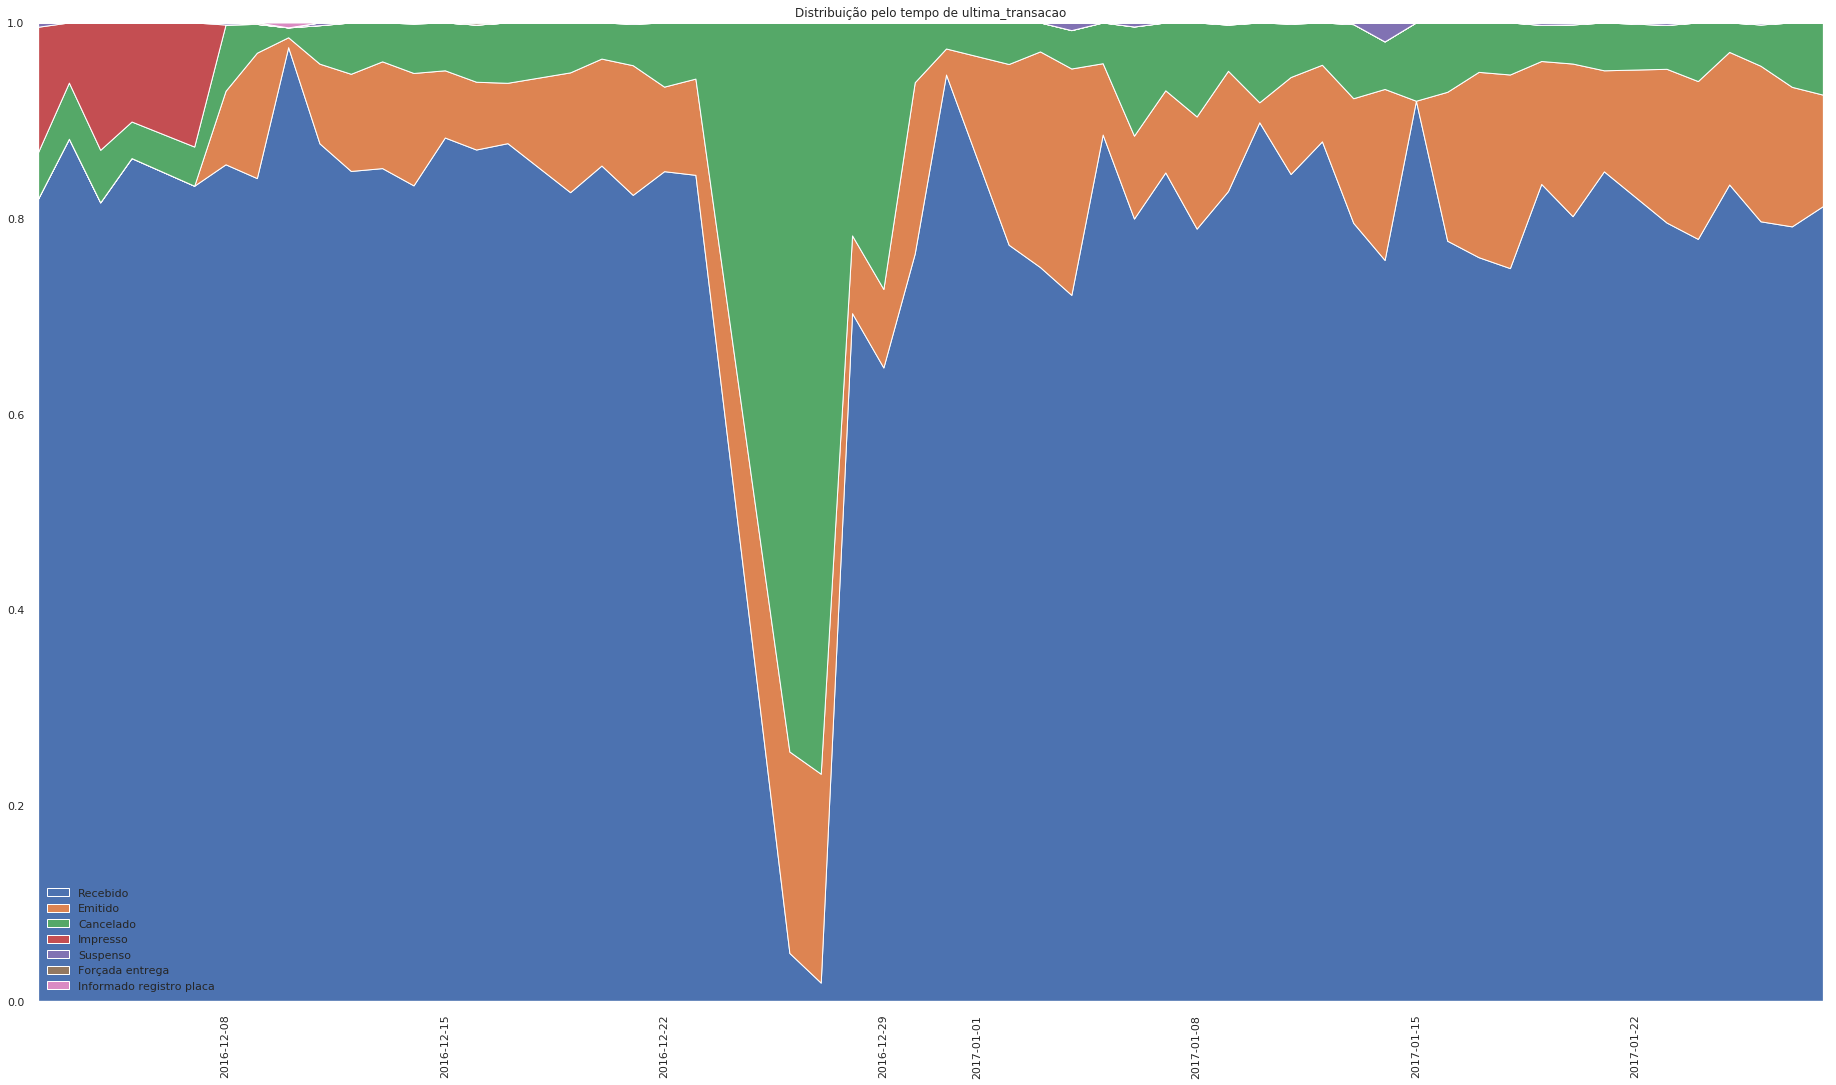

Average per year


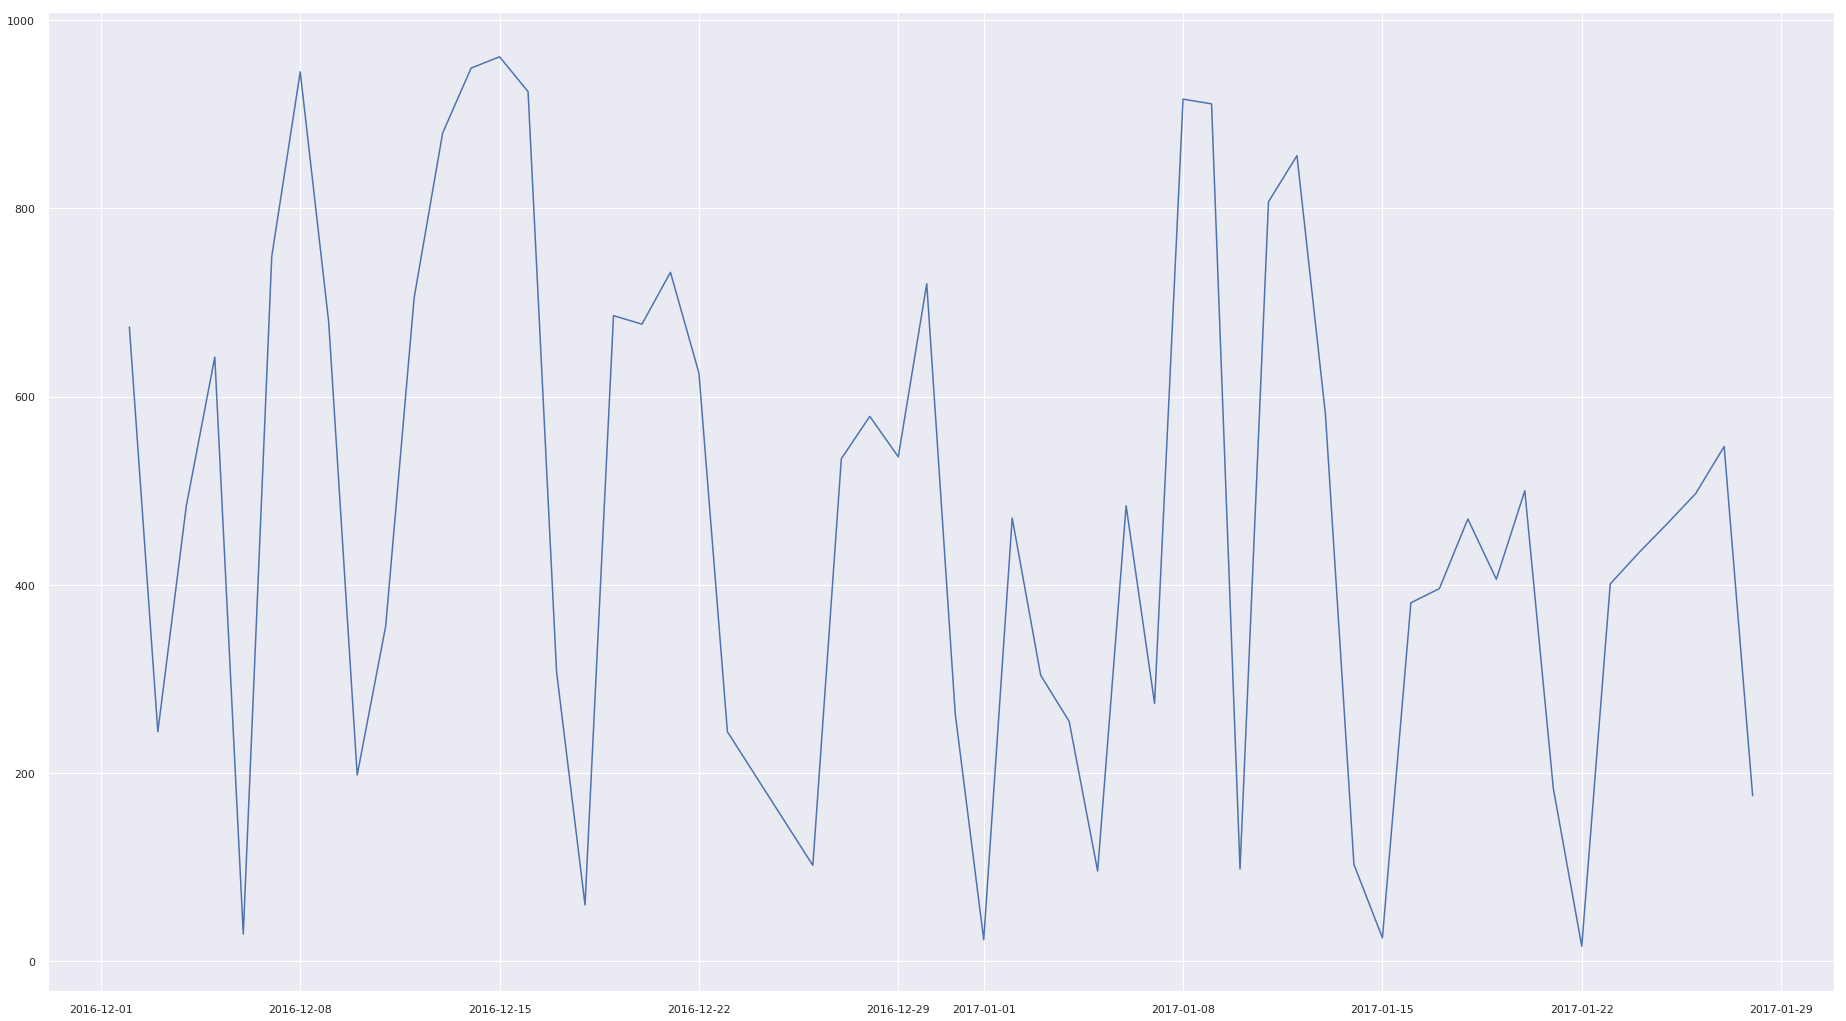

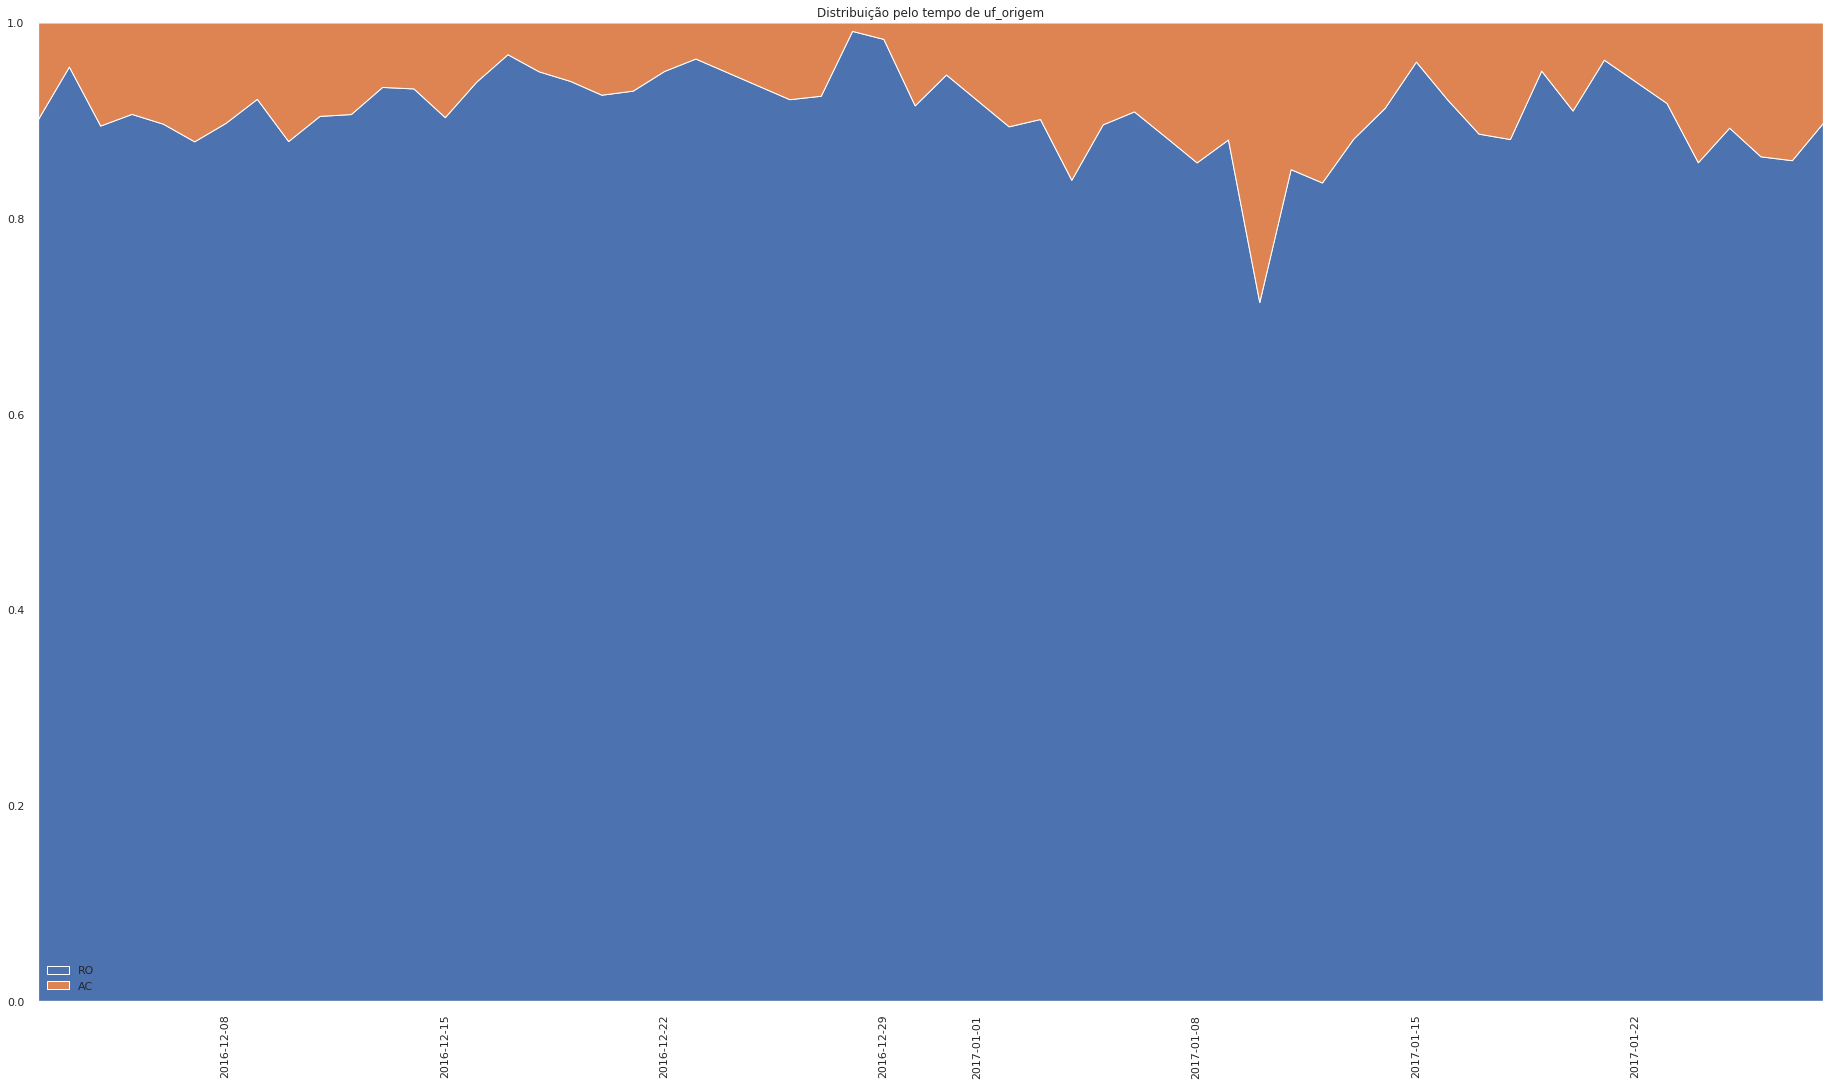

Average per year


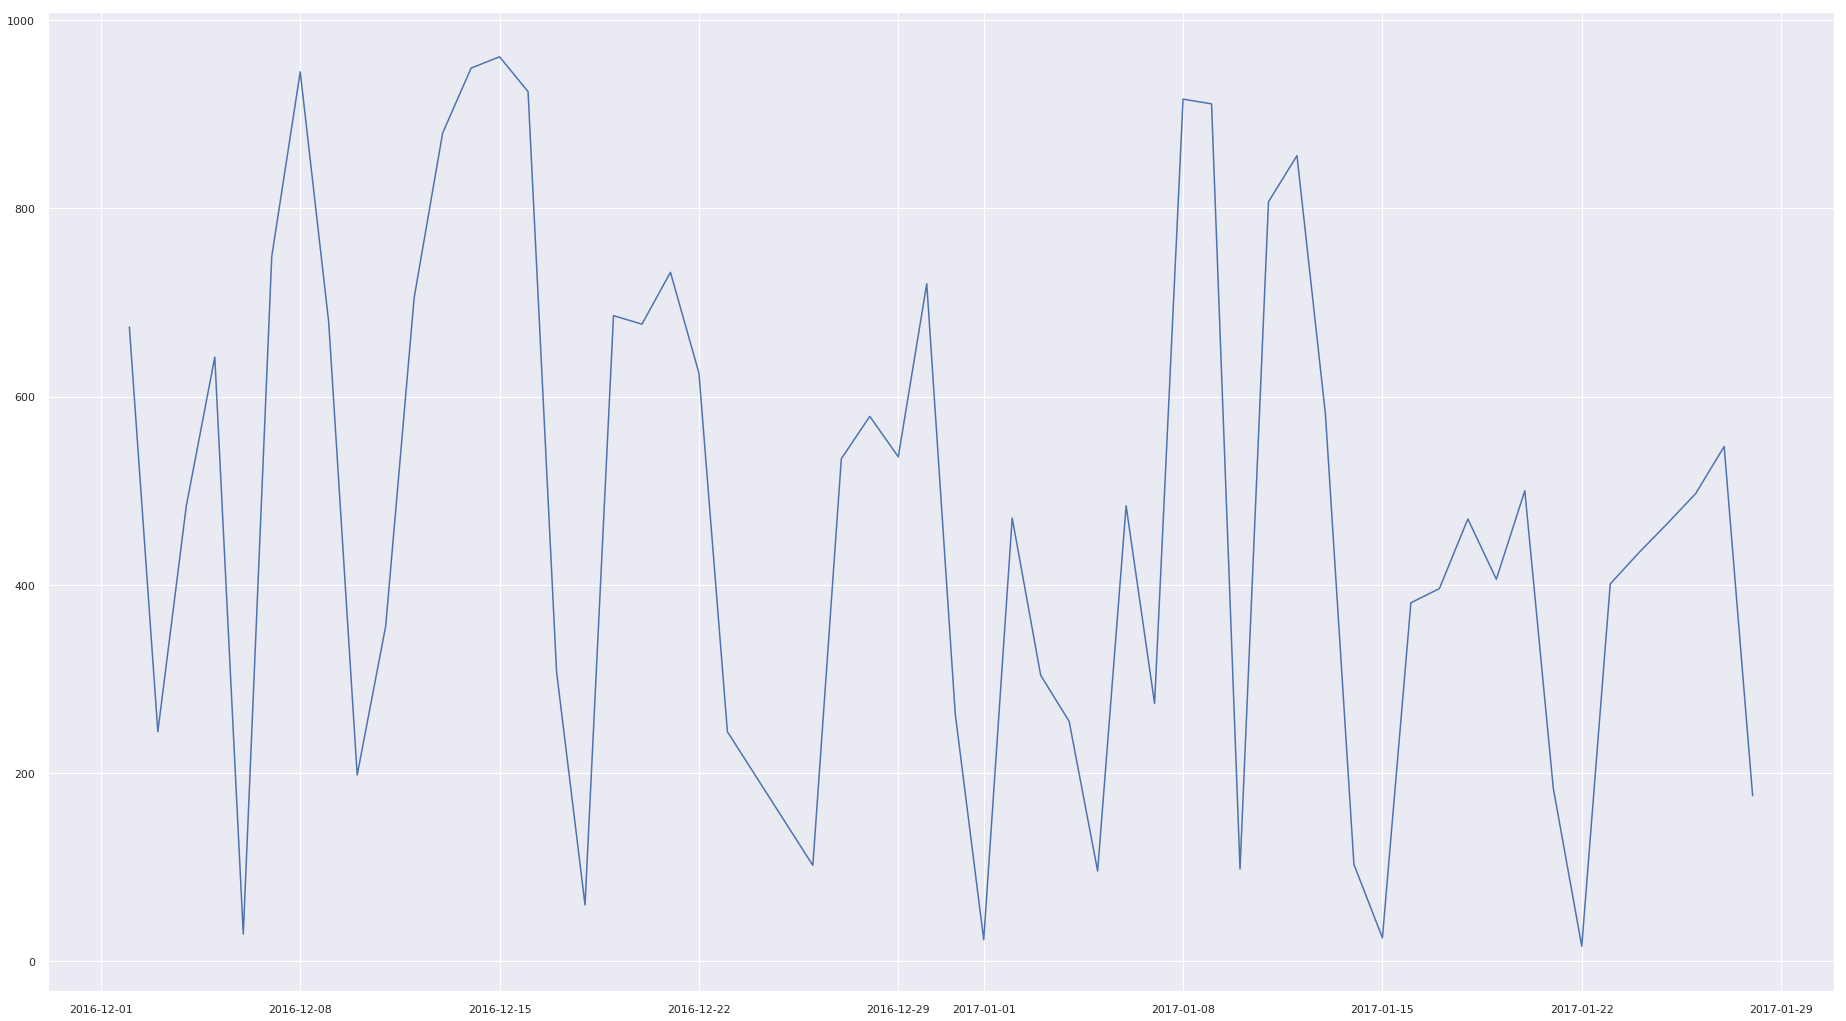

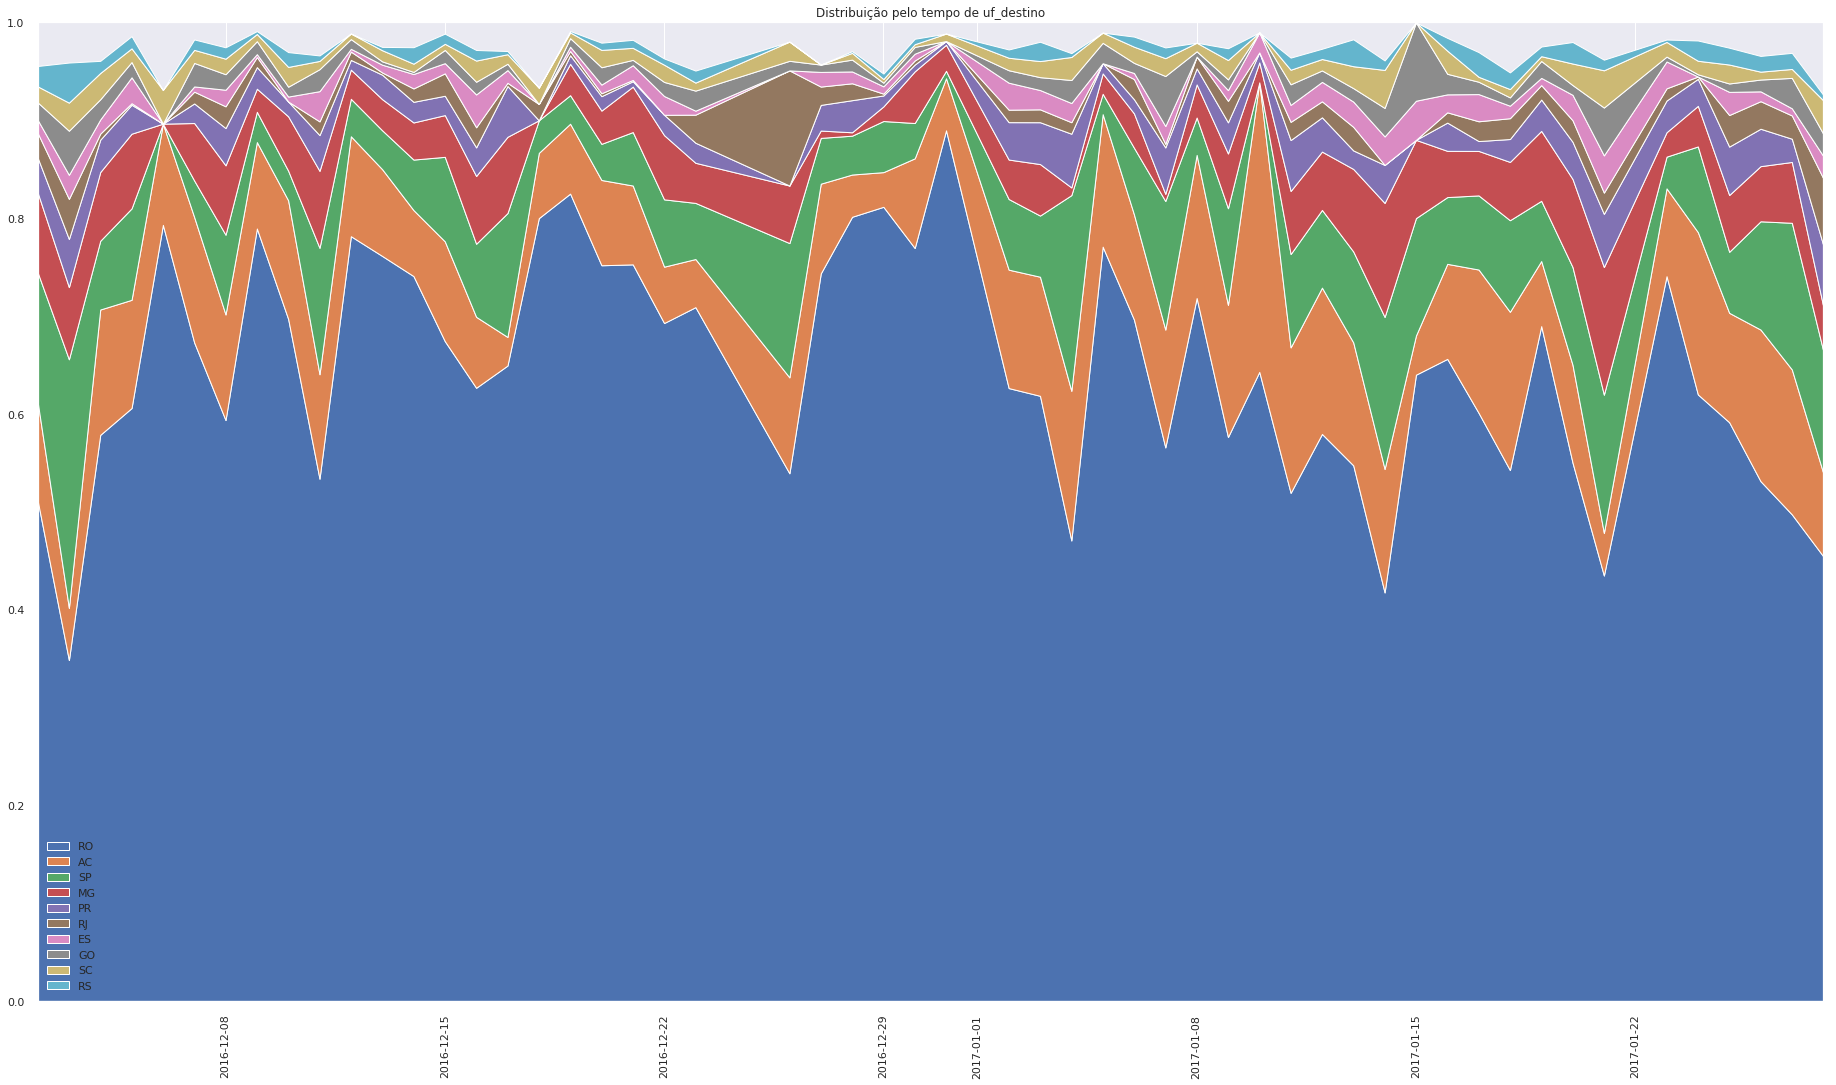

Average per year


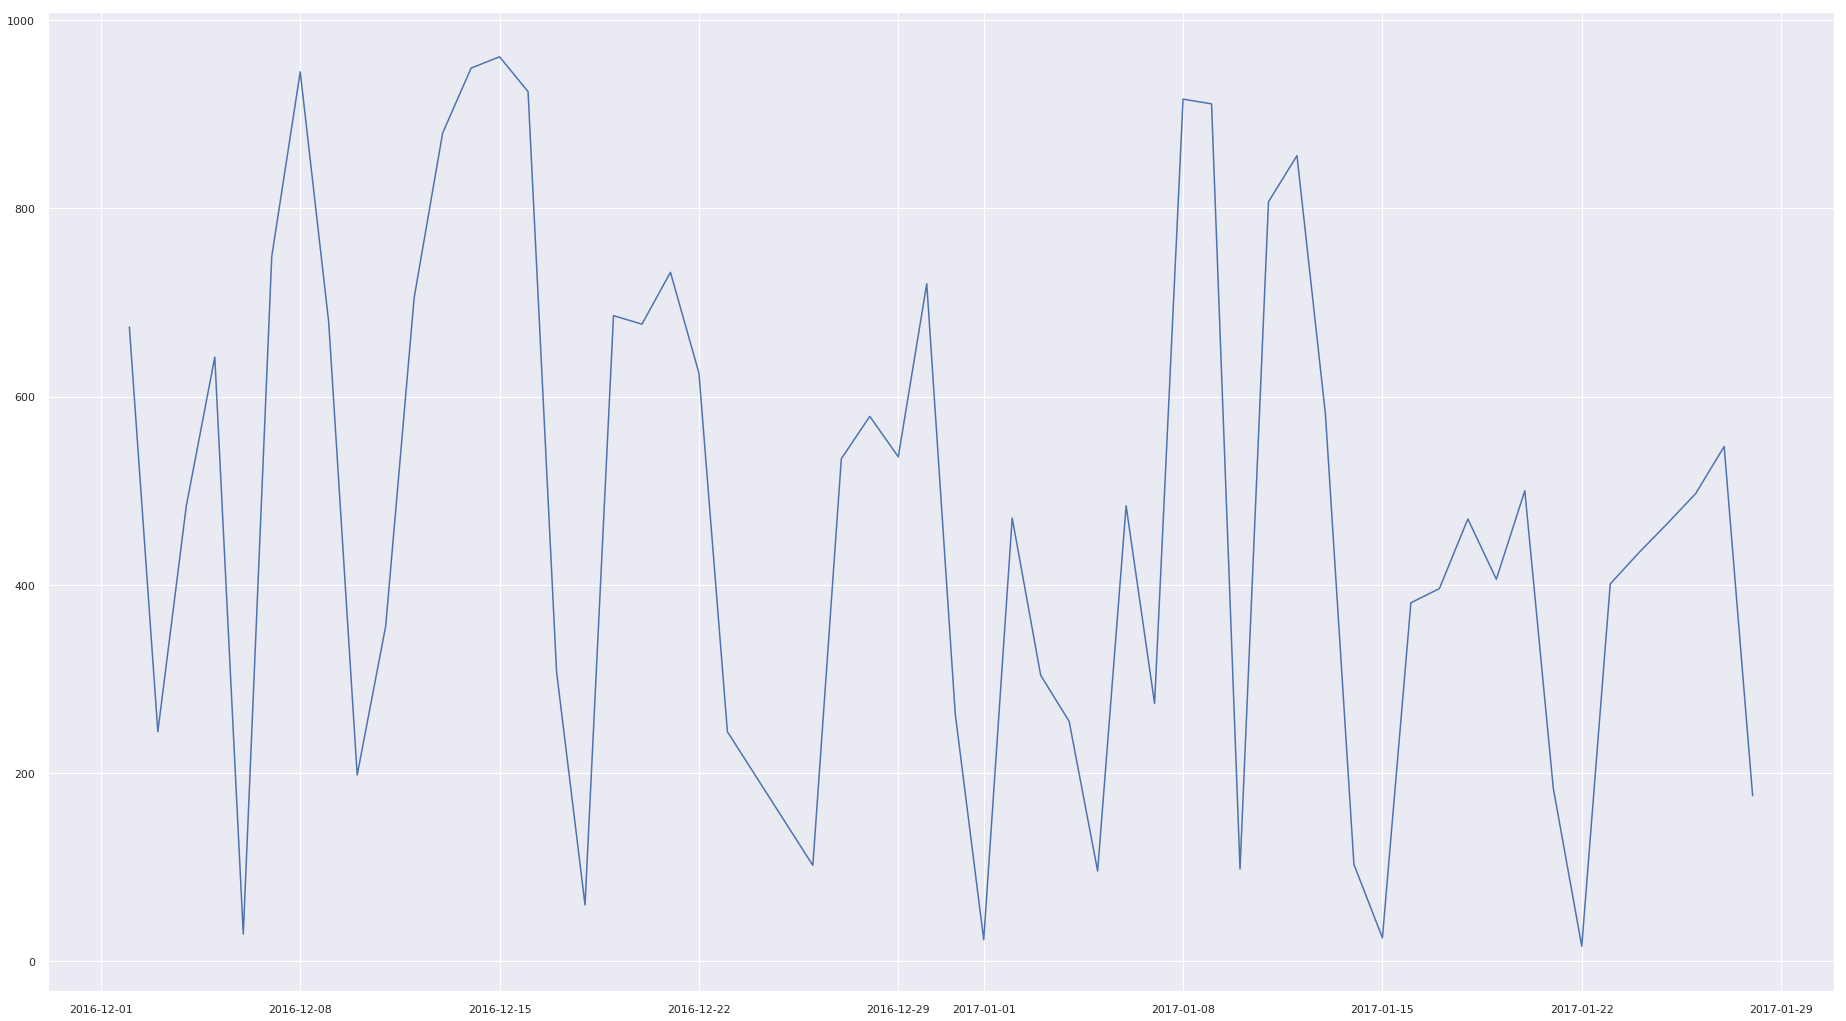

In [114]:
for col in ["ultima_transacao", "uf_origem", "uf_destino"]:
    TARGET_COL = col
    stacked_area_plot(sub_period_dof, 10)
    line_plot_over_time(sub_period_dof, amount_cols=10)

# General Time series analysis by category of "ultima_transacao"

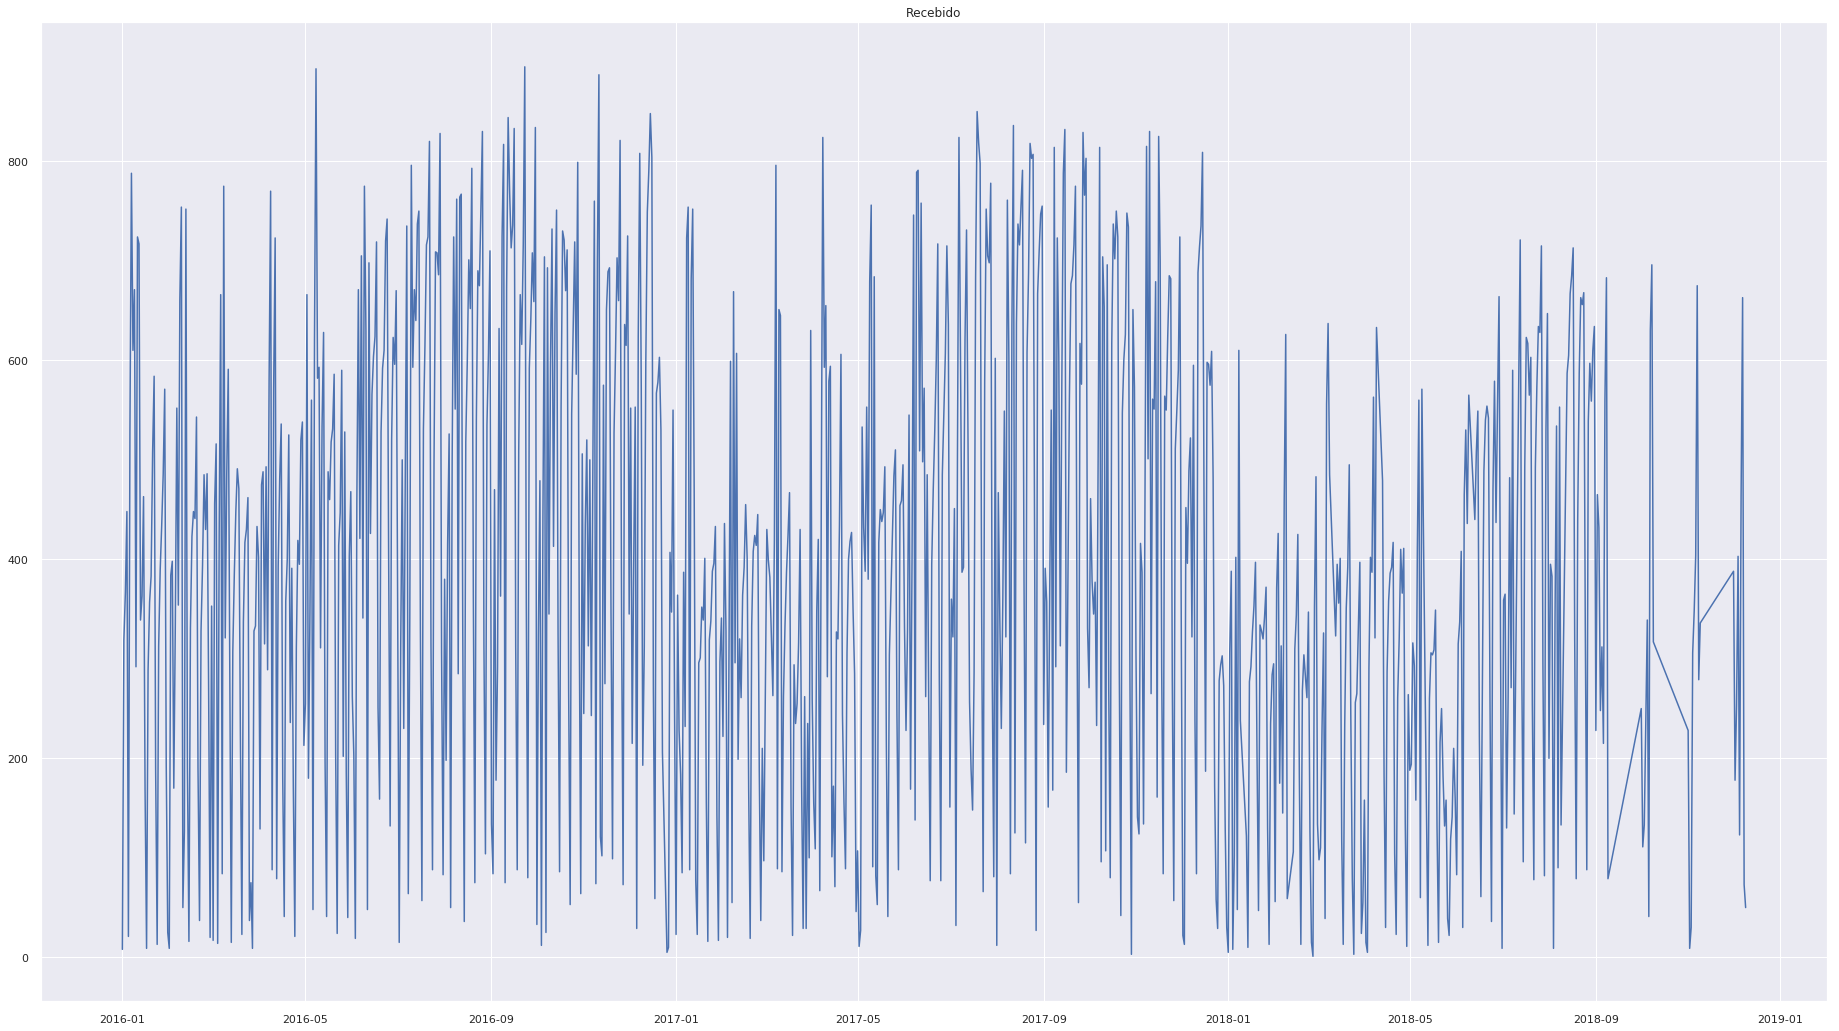

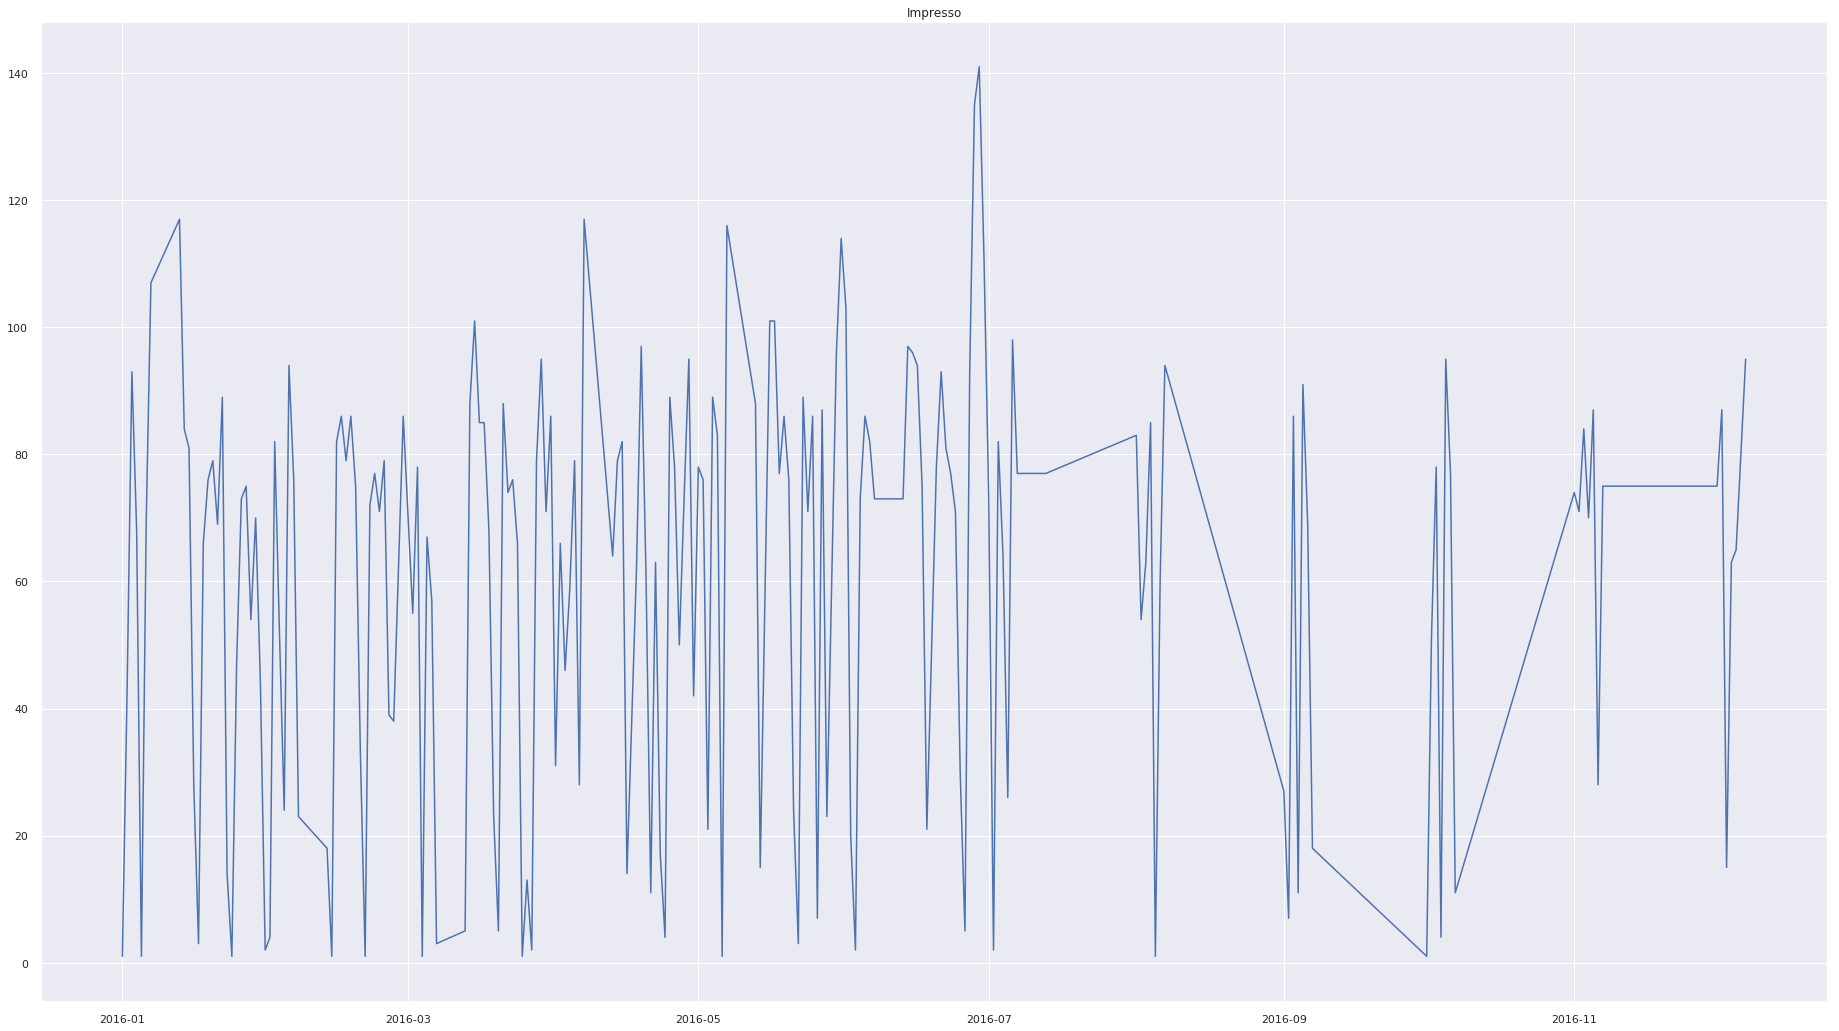

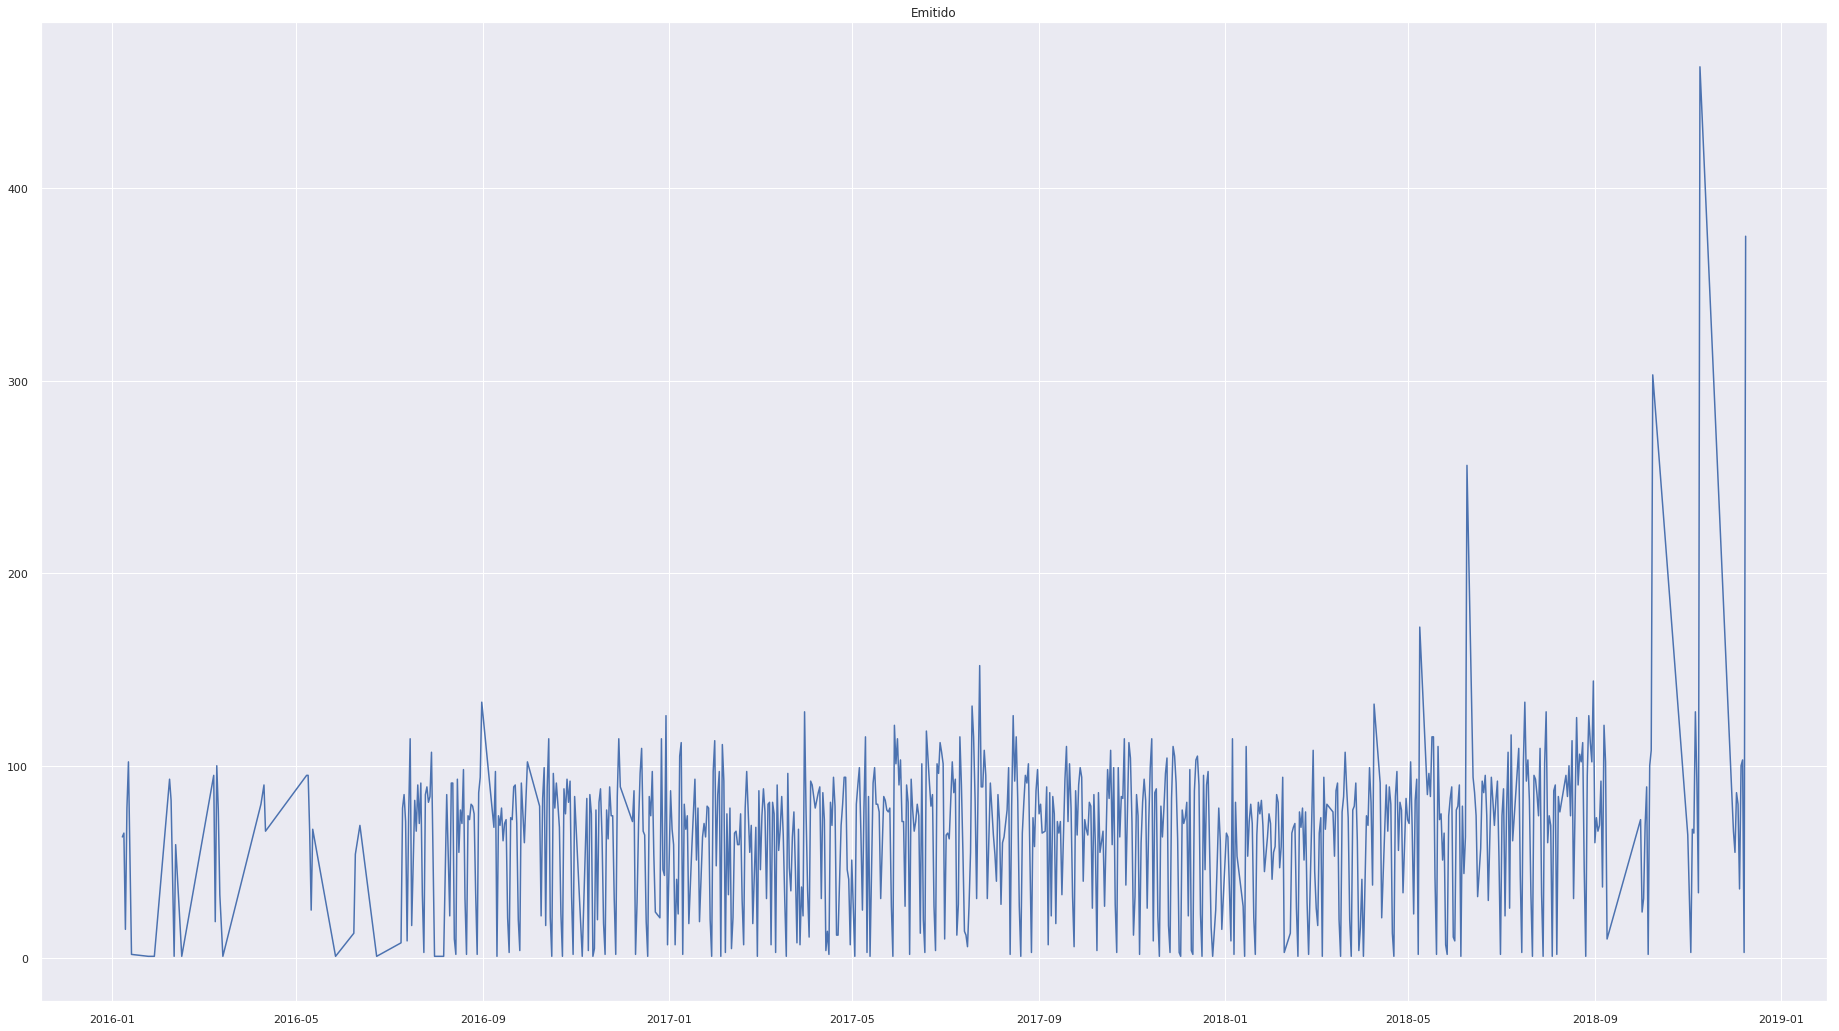

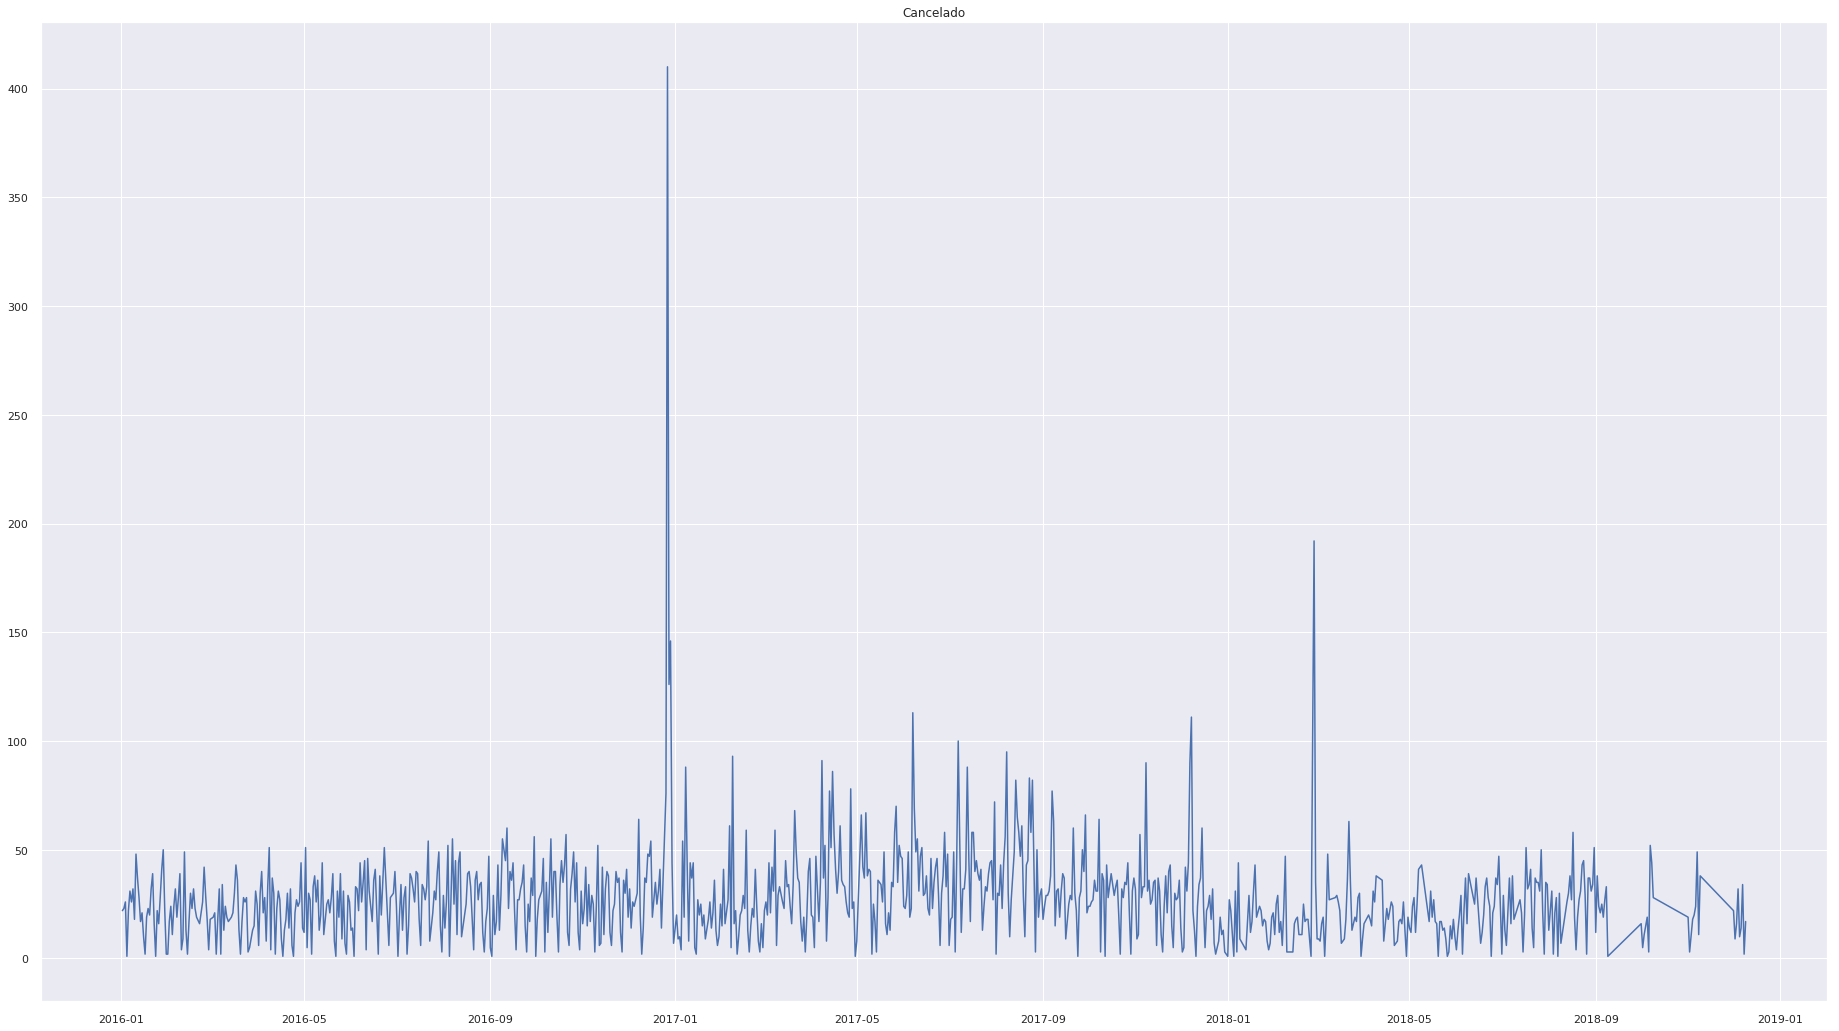

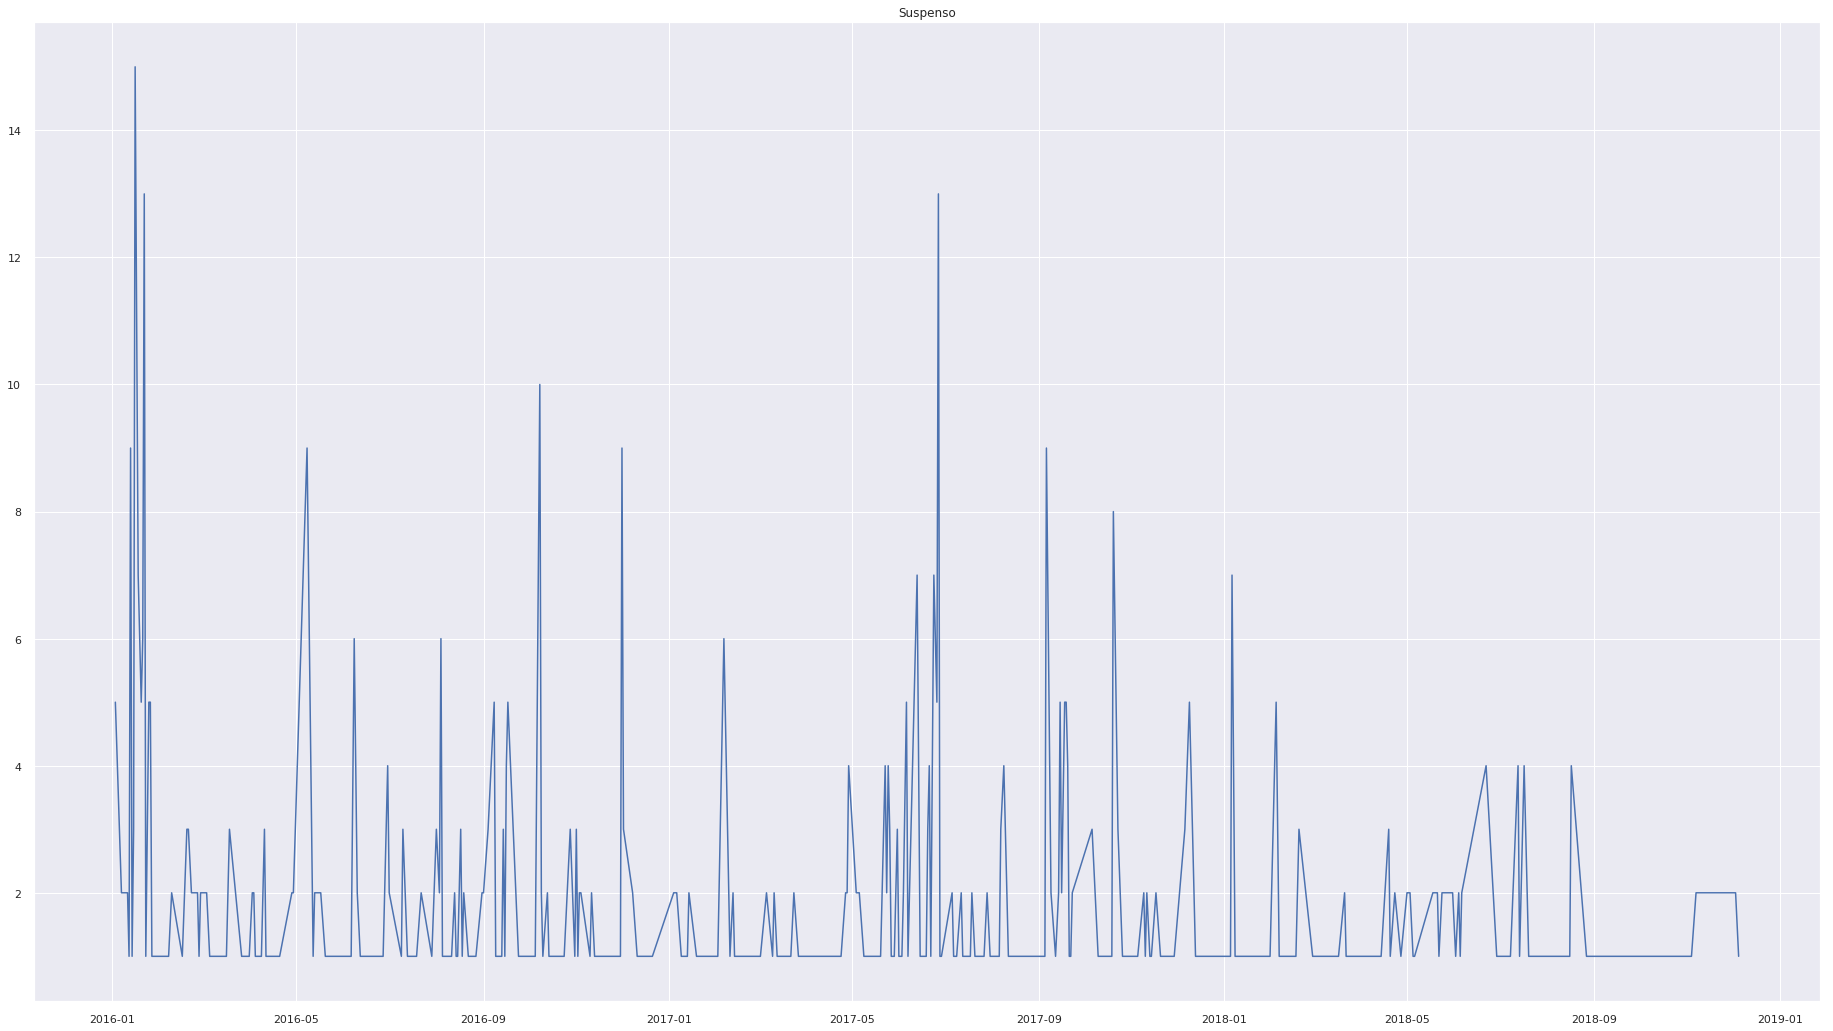

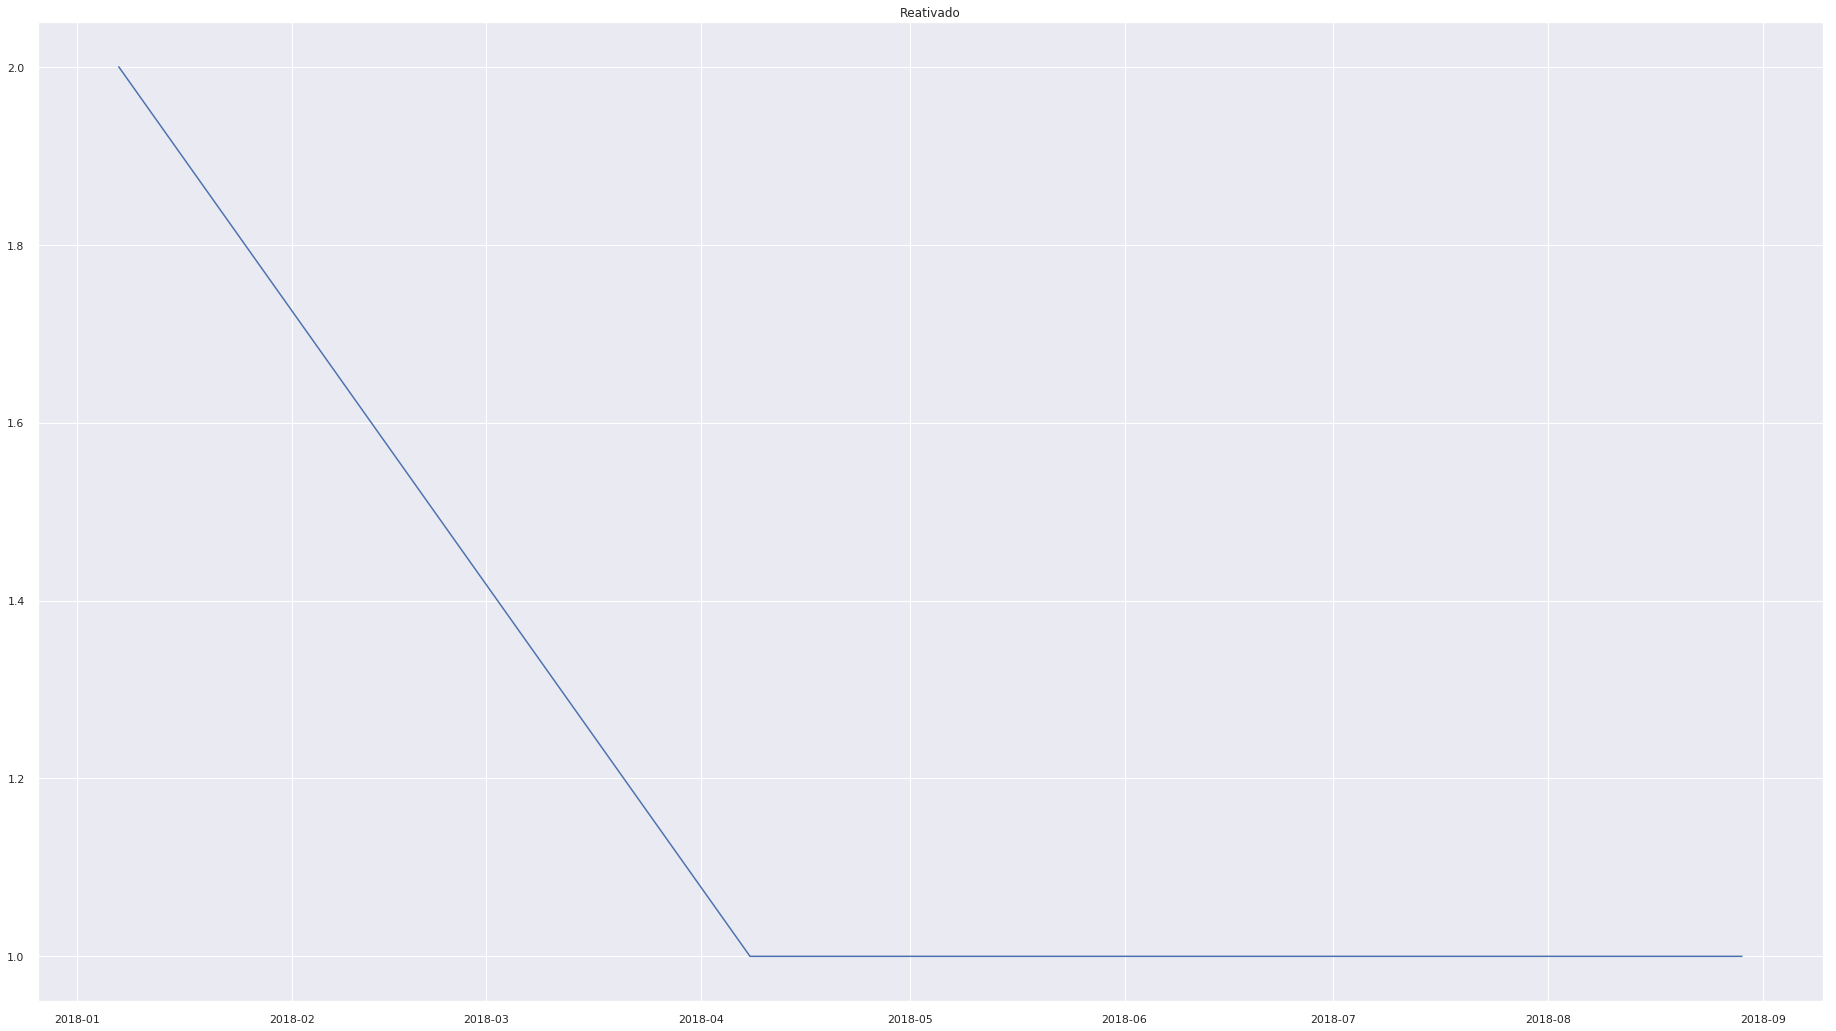

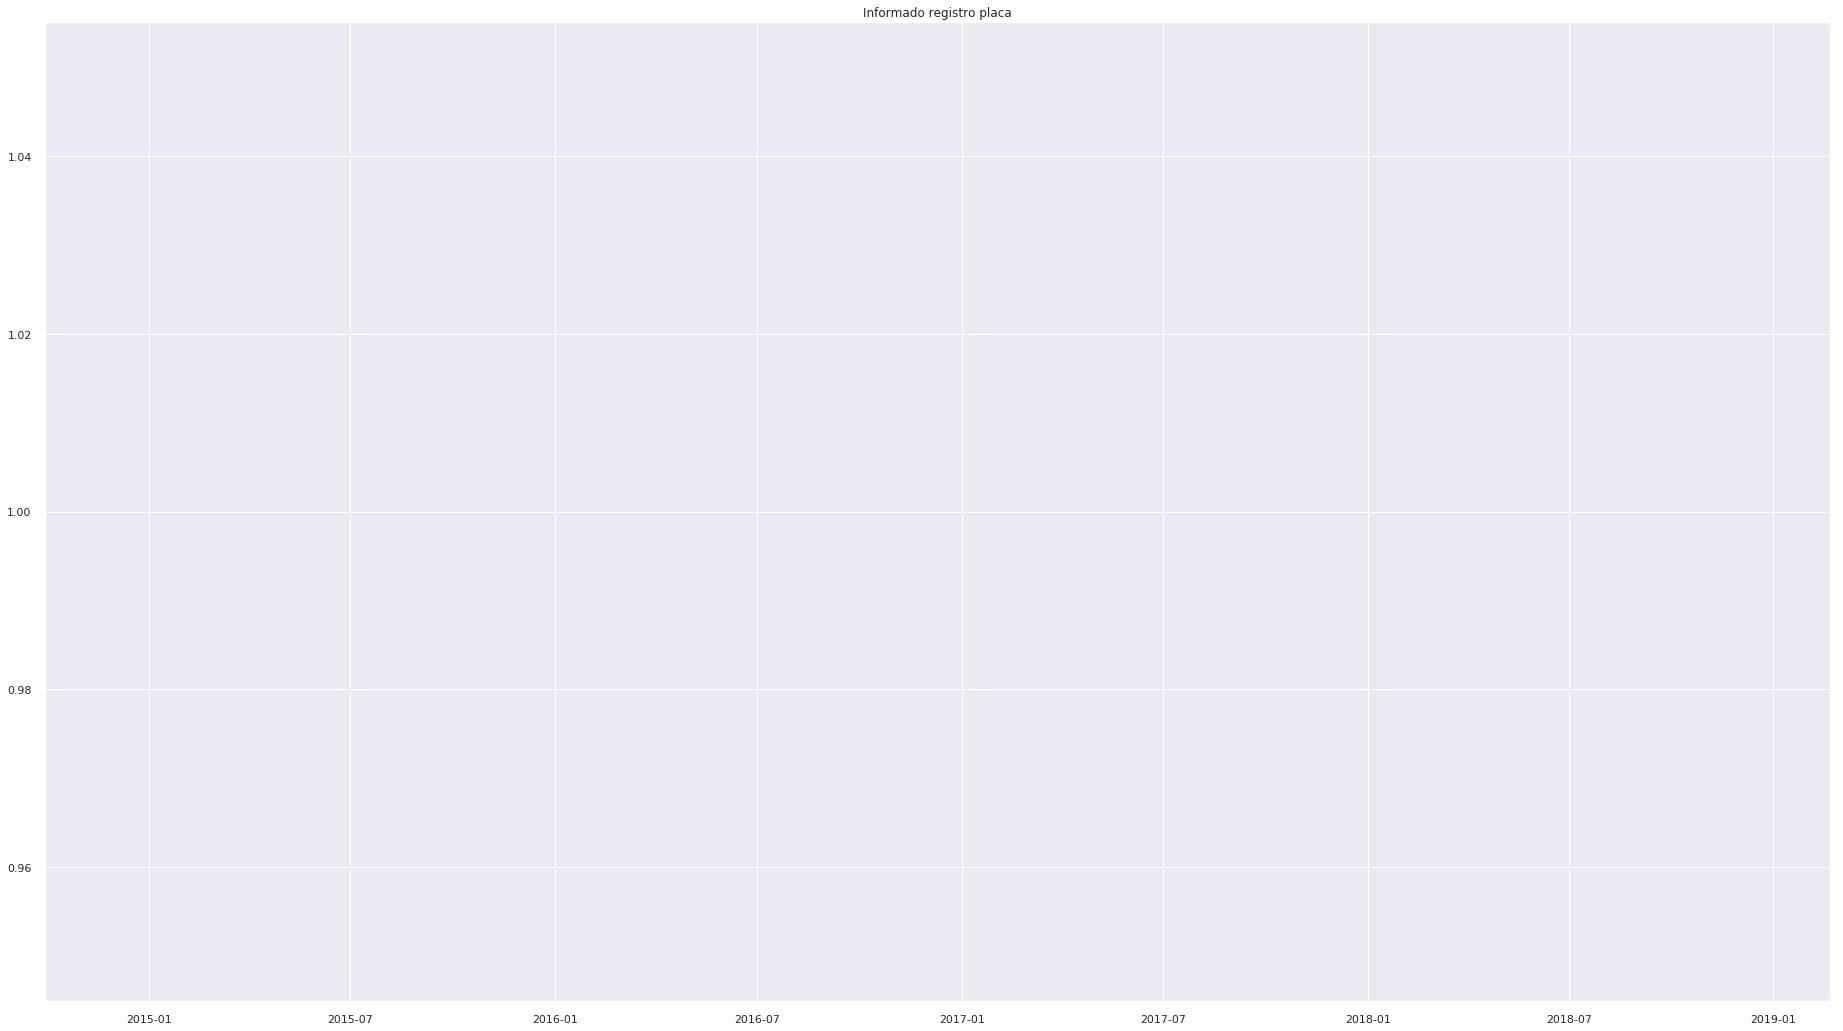

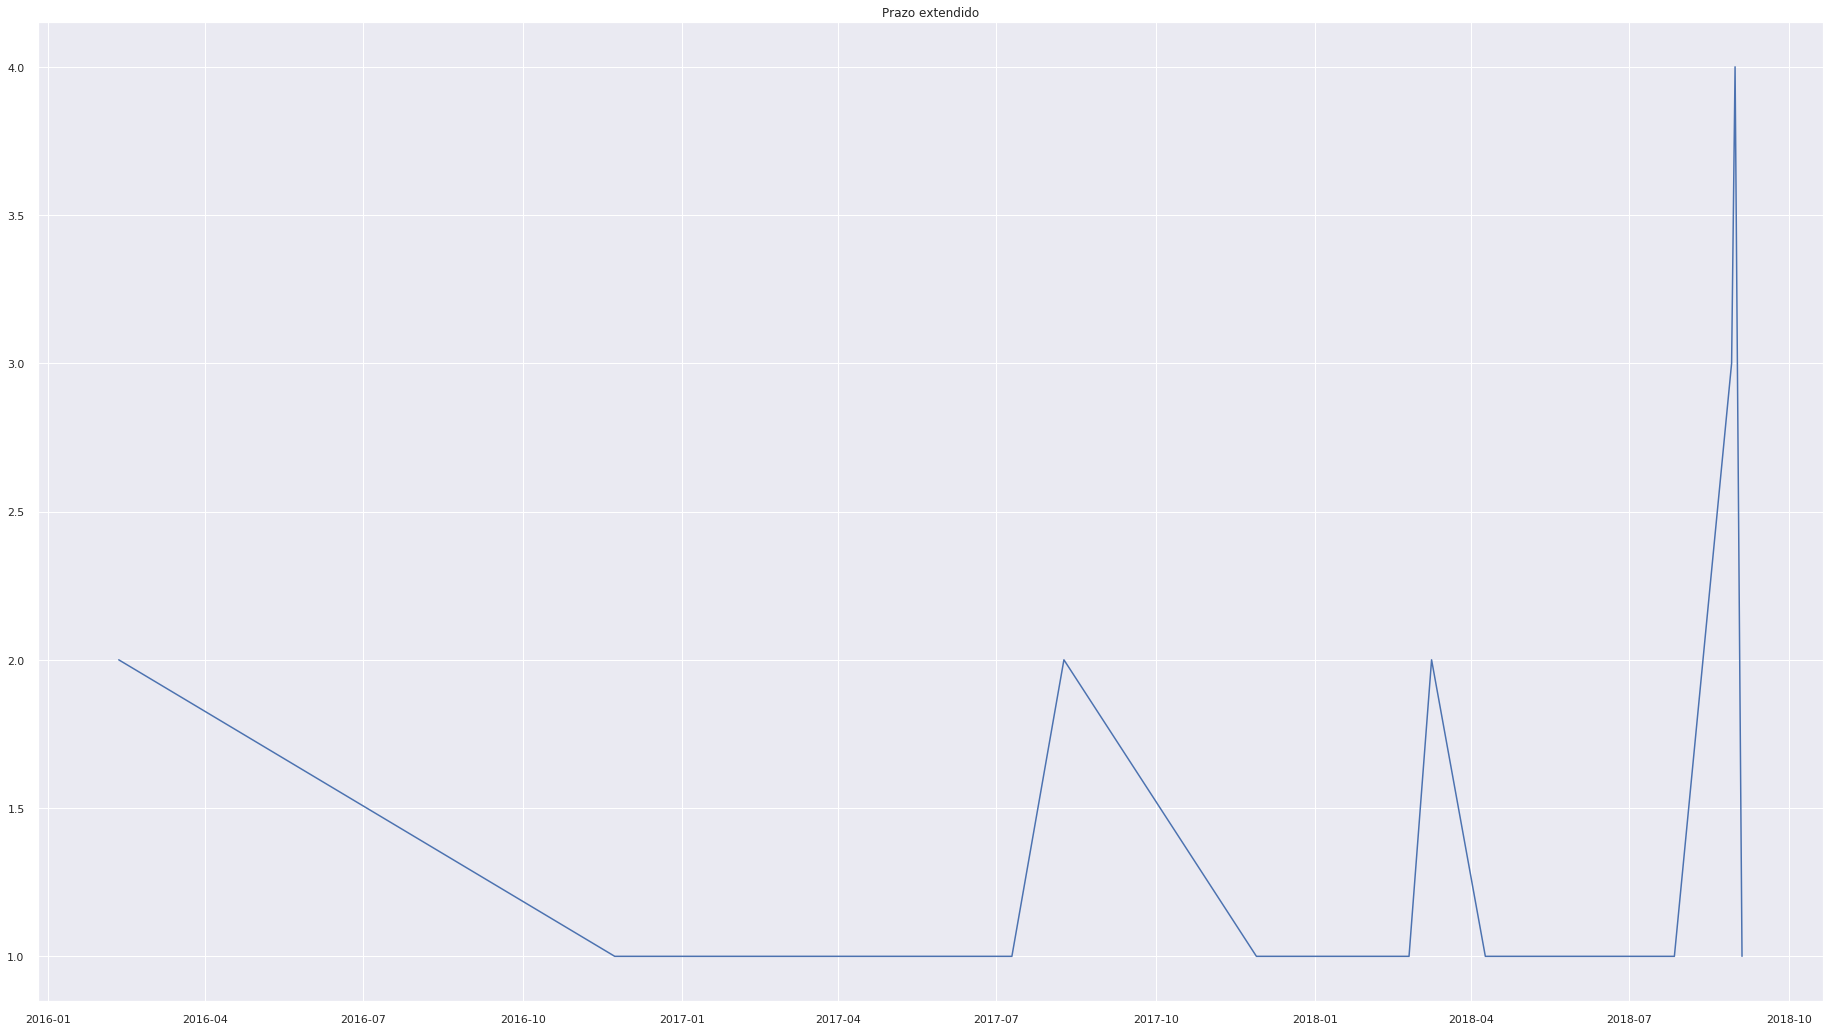

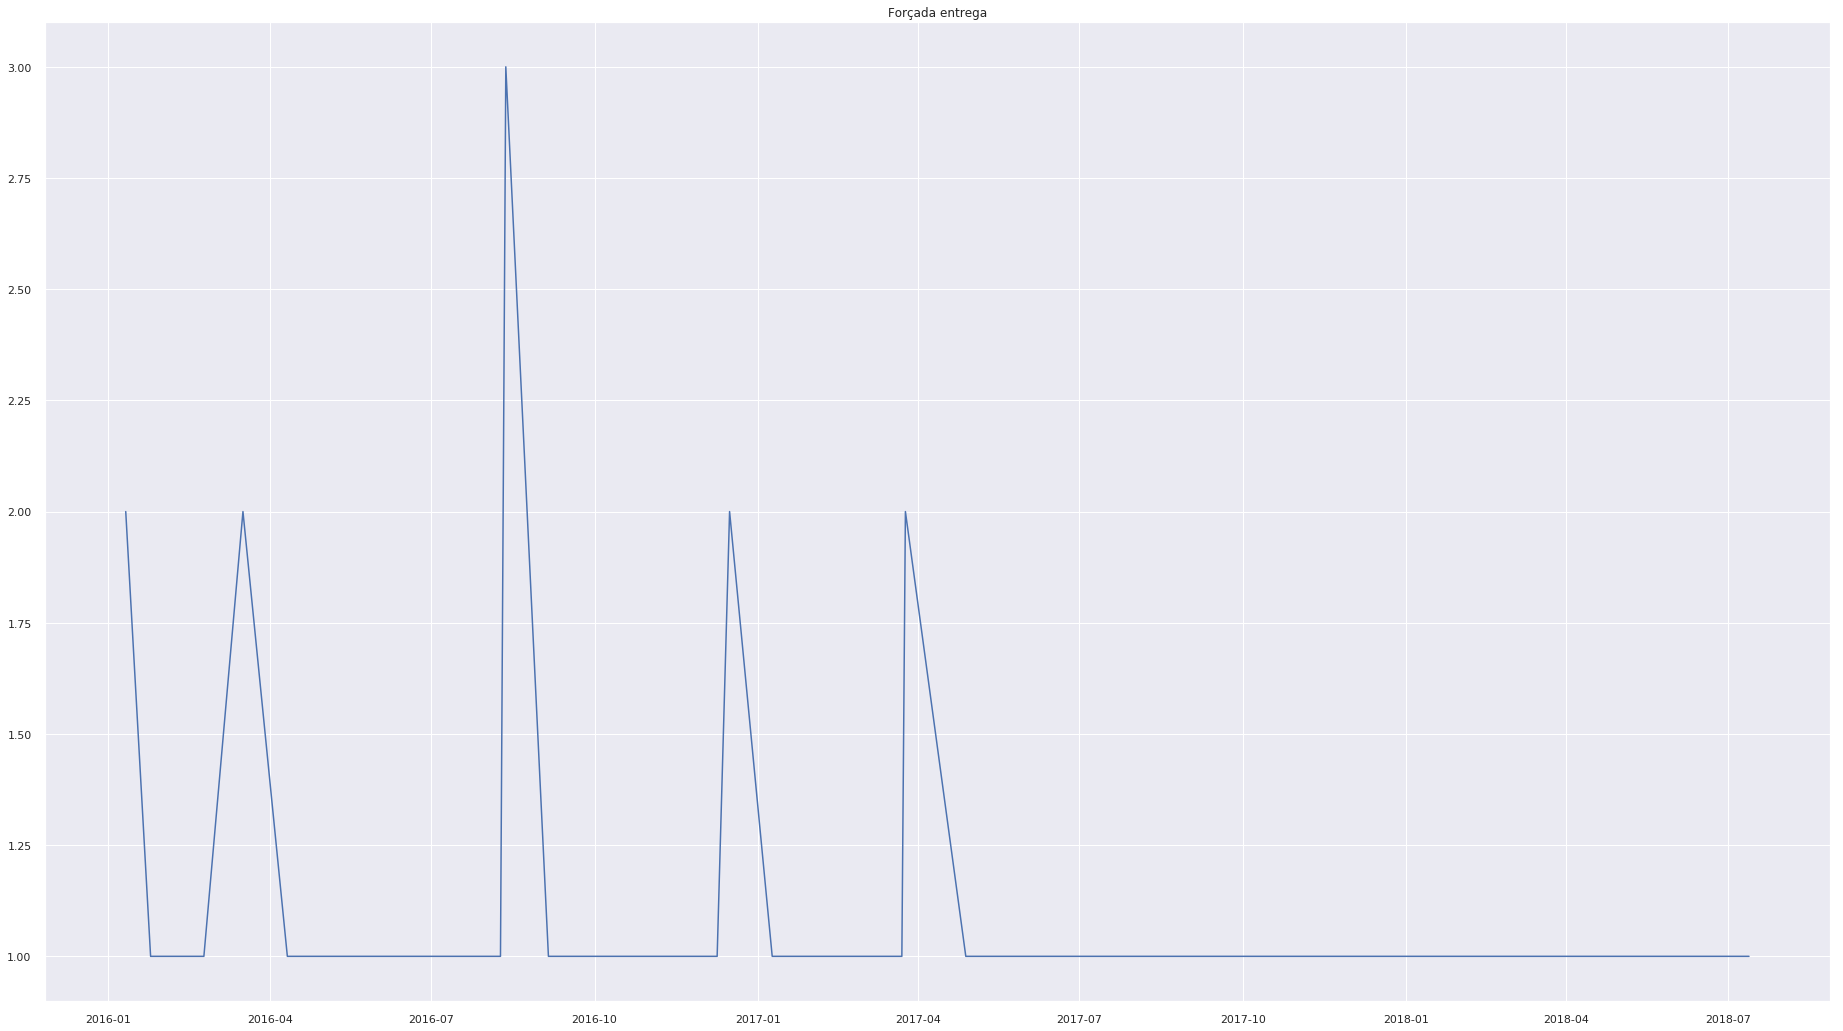

In [120]:
for group_name in df_dof["ultima_transacao"].unique():
    idx = df_dof["ultima_transacao"] == group_name
    plt.figure(figsize=(32, 18))
    sns.lineplot(data=df_dof[idx].groupby(time_col).size())
    plt.title(group_name)
    plt.show()

In [142]:
cancelled = sub_period_dof.query("ultima_transacao == 'Cancelado'")
print(cancelled.shape)
cancelled.head()

(2052, 26)


nome_remetente   cpf_remetente uf_origem  \
83        A BREVE FERREIRA ME  04745126000146        AC   
392       A NOVACK JUNIOR EPP  14182168000170        RO   
641   A R LEMES MADEIRAS - ME  19124419000183        RO   
1091           A S MEIRA - ME  07018010000101        RO   
1155           A S MEIRA - ME  07018010000101        RO   

            municipio_origem  cd_mun_origem  latitude_origem  \
83                RIO BRANCO        1200401       -10.066148   
392                ARIQUEMES        1100023        -9.951890   
641          ESPIGAO D'OESTE        1100098       -11.351340   
1091  CAMPO NOVO DE RONDONIA        1100700       -10.484934   
1155  CAMPO NOVO DE RONDONIA        1100700       -10.484934   

      longitude_origem  ctf_remetente uf_destino municipio_destino  \
83          -68.371045         502528         RO       PORTO VELHO   
392         -62.957255        5518703         SP          GUAPIACU   
641         -60.784830        5995220         RO   ESPIGAO D'OESTE   
1091        -63.799716        5006782         RO         ARIQUEMES   
1155        -63.799716        5006782         RO           BURITIS   

      cd_mun_destino  latitude_destino  longitude_destino  \
83           1100205         -9.153593         -64.306814   
392          3517505        -20.742853         -49.189913   
641          1100098        -11.351340         -60.784830   
1091         1100023         -9.951890         -62.957255   
1155         1100452        -10.052115         -63.941163   

                                      nome_destinatario cpf_destinatario  \
83    AGROMAD INDUSTRIA E COMERCIO DE MADEIRAS LTDA EPP   09320992000109   
392          MOVEIS PROVINCIA INDUSTRIA E COMERCIO LTDA   48315477000192   
641                               MADEIREIRA BAMBÚ LTDA   11602746000191   
1091            ÁGUIA IMPORTAÇÃO E EXPORTAÇÃO LTDA - ME   08359672000108   
1155                         LEONILDO TEIXEIRA DA SILVA   14570938000151   

     dt_emissao   ano dt_validade_inicial dt_validade_final ultima_transacao  \
83   2016-12-04  2016          2016-12-04        2016-04-16        Cancelado   
392  2017-01-16  2017          2017-01-16        2017-01-22        Cancelado   
641  2016-12-15  2016          2016-12-15        2016-12-18        Cancelado   
1091 2016-12-22  2016          2016-12-22        2016-12-25        Cancelado   
1155 2016-12-21  2016          2016-12-21        2016-12-24        Cancelado   

     dt_ultima_transacao  numero_serie_dof  codigo_controle_dof  \
83            2016-12-04          15881533     1198843447571255   
392           2017-01-16          17262589     1523971432196425   
641           2016-12-15          17131101     5652616136766246   
1091          2016-12-22          17170572     1892875397941723   
1155          2016-12-21          17165229     6224723151339225   

                             rota_transporte   volume  valor  
83              RIO BRANCO/AC-PORTO VELHO/RO  29.1947    0.0  
392                 ARIQUEMES/RO-GUAPIACU/SP  19.9595    0.0  
641    ESPIGAO D'OESTE/RO-ESPIGAO D'OESTE/RO   0.5532    0.0  
1091  CAMPO NOVO DE RONDONIA/RO-ARIQUEMES/RO  36.7120    0.0  
1155    CAMPO NOVO DE RONDONIA/RO-BURITIS/RO  25.0000    0.0